In [9]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import nibabel as nib
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power
from inrmri.utils_rdls import seconds_to_min_sec_format, filter_and_get_columns, apply_transform

from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.image_processor import reduce_FOV 

from inrmri.utils_rdls import safe_normalize, get_center

from inrmri.utils_rdls import get_info_volunteer, read_segmentation, read_ref_dataset

## General

In [10]:
total_slices          = 8
num_frames            = 30
base_path             = '/mnt/workspace/datasets/pulseqCINE/'
target_columns        = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]', 'duration [s]']

## Volunteer

In [11]:
dataset        = 'DATA_0.55T'
volunteer      = 'MP'
# --- PATH ---
base_folder                     = base_path + dataset + '/' + volunteer + '/'
train_data_folder               = base_folder + 'traindata/'
segmentation_folder             = base_folder + 'segmentations/'
segmentation_endocardium_folder = segmentation_folder + 'endocardium/'
segmentation_septum_folder      = segmentation_folder + 'septum/'

In [12]:
es_folder = base_folder + 'es/'
if not os.path.exists(es_folder):
    os.makedirs(es_folder)

## DIP Model reconstructions

In [13]:
stdip_parameters = {
    'experiment_name': 'total_kiter_lambda_denoise_reg', 
    'training_params': {
        'total_kiter':3000,
        'lambda_denoise_reg':1e-7,
        'slice':None,
    }
}
tddip_parameters = {
    'experiment_name': 'total_kiter', 
    'training_params': {
        'total_kiter':2000,
        'slice':None,
    }
}

In [14]:
stdip_parameters['path']               = base_folder + 'stDIP'
stdip_parameters['csv_path']           = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + ".csv"
stdip_parameters['csv_path_summary']   = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + "_summary.csv"

In [15]:
tddip_parameters['path']               = base_folder + 'tdDIP'
tddip_parameters['csv_path']           = tddip_parameters['path'] +  '/' + tddip_parameters['experiment_name'] + ".csv"
tddip_parameters['csv_path_summary']   = tddip_parameters['path'] +  '/' + tddip_parameters['experiment_name'] + "_summary.csv"

## Data

In [16]:
import os

all_slices_data = []

for i in range(1, total_slices + 1):
    print(f'slice {i}')
    slice_data = {}

    # === Volunteer and Training Parameters ===
    volunteer_params = get_info_volunteer(dataset, volunteer, i)
    stdip_parameters['training_params']['slice'] = i
    tddip_parameters['training_params']['slice'] = i

    # === Reference Dataset Path ===
    dataset_name = f'slice_{i}_{total_slices}_nbins{num_frames}'
    path_dataset = os.path.join(train_data_folder, f'{dataset_name}.npz')

    # === Reference Reconstructions ===
    recon_fs, recon_grasp, recon_sense, time_grasp, time_sense = read_ref_dataset(path_dataset)
    recon_grasp    = get_center(recon_grasp) 
    recon_sense    = get_center(recon_sense)
    recon_fs       = get_center(recon_fs) 
    recon_grasp    = safe_normalize(recon_grasp) 
    recon_sense    = safe_normalize(recon_sense) 
    recon_fs       = safe_normalize(recon_fs) 
    recon_fs = apply_transform(recon_fs, volunteer_params['trans_gt'])
    recon_grasp = apply_transform(recon_grasp, volunteer_params['trans'])
    recon_sense = apply_transform(recon_sense, volunteer_params['trans'])
    slice_data['recon'] = {
        'fs': recon_fs,
        'grasp': recon_grasp,
        'sense': recon_sense
    }

    # === stDIP Reconstruction ===
    stdip_parameters['exp_folder_path'] = os.path.join(stdip_parameters['path'], dataset_name, stdip_parameters['experiment_name'])
    df_stdip = pd.read_csv(stdip_parameters['csv_path'], delimiter=';')
    stDIP_results = filter_and_get_columns(df_stdip, stdip_parameters['training_params'], target_columns)[0]
    stdip_parameters['best_recon_path'] = os.path.join(stdip_parameters['exp_folder_path'], stDIP_results['training_name'], 'best_recon.npz')
    recon_stdip = onp.load(stdip_parameters['best_recon_path'], allow_pickle=True)['best_recon']
    recon_stdip = safe_normalize(recon_stdip)
    recon_stdip = apply_transform(recon_stdip, volunteer_params['trans'])
    slice_data['recon']['stdip'] = recon_stdip

    # === tdDIP Reconstruction ===
    tddip_parameters['exp_folder_path'] = os.path.join(tddip_parameters['path'], dataset_name, tddip_parameters['experiment_name'])
    df_tddip = pd.read_csv(tddip_parameters['csv_path'], delimiter=';')
    tdDIP_results = filter_and_get_columns(df_tddip, tddip_parameters['training_params'], target_columns)[0]
    tddip_parameters['best_recon_path'] = os.path.join(tddip_parameters['exp_folder_path'], tdDIP_results['training_name'], 'best_recon.npz')
    recon_tddip = onp.load(tddip_parameters['best_recon_path'], allow_pickle=True)['best_recon']
    recon_tddip = safe_normalize(recon_tddip)
    recon_tddip = apply_transform(recon_tddip, volunteer_params['trans'])
    slice_data['recon']['tddip'] = recon_tddip

    # === FS Segmentations ===
    seg_endo, seg_endo_fill, seg_end_area = read_segmentation(
        os.path.join(segmentation_endocardium_folder, f"{volunteer}_recon_fs_slice{i}.nii"))
    seg_sep = read_segmentation(
        os.path.join(segmentation_septum_folder, f"{volunteer}_recon_fs_slice{i}.nii"), fill=False)
    slice_data['segmentation'] = {
        'fs': {
            'sep': seg_sep,
            'endo': seg_endo,
            'endo_fill': seg_endo_fill,
            'area_ed': seg_end_area[volunteer_params['EF_frames']['EDV_gt']],
            'area_es': seg_end_area[volunteer_params['EF_frames']['ESV_gt']]
        }
    }

    # === stDIP Segmentations ===
    seg_endo, seg_endo_fill, seg_end_area = read_segmentation(
        os.path.join(segmentation_septum_folder, f"{volunteer}_stdip_slice{i}.nii"))
    seg_sep = read_segmentation(
        os.path.join(segmentation_septum_folder, f"{volunteer}_stdip_slice{i}.nii"), fill=False)
    slice_data['segmentation']['stdip'] = {
        'sep': seg_sep,
        'endo': seg_endo,
        'endo_fill': seg_endo_fill,
        'area_ed': seg_end_area[volunteer_params['EF_frames']['EDV']],
        'area_es': seg_end_area[volunteer_params['EF_frames']['ESV']]
    }

    # === Save Slice Info ===
    slice_data['metadata'] = {
        'slice_number': i,
        'dataset_name': dataset_name,
        'volunteer_params': volunteer_params
    }

    all_slices_data.append(slice_data)


slice 1


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/MP/stDIP/total_kiter_lambda_denoise_reg.csv'

# 1 .- Select points

## 1.1 .- Test with random point

In [9]:
from scipy.ndimage import center_of_mass

def get_center_of_mass(segmentation_2d):
    cy, cx = center_of_mass(segmentation_2d)
    return cy, cx

def get_center_of_mass_dict(segmentation_3d):
    centers_dict = {
        'cx': [], 
        'cy': []
    }
    for i in range(segmentation_3d.shape[-1]):
        cy, cx = get_center_of_mass(segmentation_3d[..., i])
        centers_dict['cy'].append(  cy  )
        centers_dict['cx'].append(  cx  )
    return centers_dict
    
def get_random_point(segmentation):
    """Returns a random (row, col) point from a 2D binary segmentation."""
    indices = onp.argwhere(segmentation > 0)
    if indices.size == 0:
        raise ValueError("Segmentation is empty.")
    random_index = onp.random.choice(len(indices))
    return tuple(indices[random_index])

def get_random_point_list(segmentation_3d):
    random_dict = {
        'cx': [], 
        'cy': []
    }
    for i in range(segmentation_3d.shape[-1]):
        cy, cx = get_random_point(segmentation_3d[..., i])
        random_dict['cy'].append(  cy  )
        random_dict['cx'].append(  cx  )
    return random_dict

In [10]:
slice_data = all_slices_data[0]
recon = np.abs(slice_data['recon']['fs'])
centers_dict = get_center_of_mass_dict(slice_data['segmentation']['fs']['endo'])
random_dict  = get_random_point_list(slice_data['segmentation']['fs']['sep'])

vmax = slice_data['metadata']['volunteer_params']['saturation']

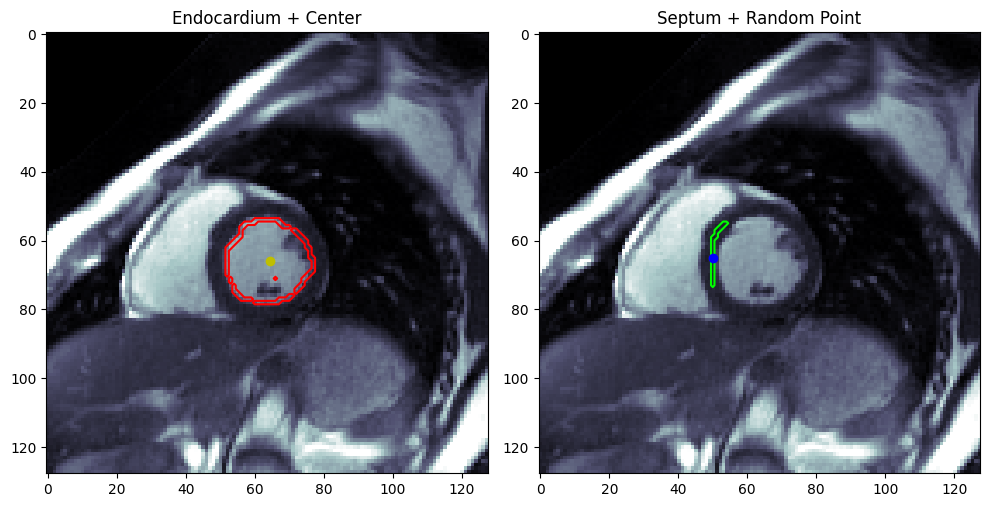

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# --- Left subplot: Endocardium + center ---
ax = axes[0]
ax.imshow(np.clip(recon[:, :, 0], 0, vmax), cmap='bone', vmin=0, vmax=vmax)
ax.contour(slice_data['segmentation']['fs']['endo'][:, :, 0], levels=[0.5], colors='red', linewidths=1.5)
ax.plot(centers_dict['cx'][0], centers_dict['cy'][0], 'yo', markersize=6)
ax.set_title('Endocardium + Center')

# --- Right subplot: Septum + random point ---
ax = axes[1]
ax.imshow(np.clip(recon[:, :, 0], 0, vmax), cmap='bone', vmin=0, vmax=vmax)
ax.contour(slice_data['segmentation']['fs']['sep'][:, :, 0], levels=[0.5], colors='lime', linewidths=1.5)
ax.plot(random_dict['cx'][0], random_dict['cy'][0], 'bo', markersize=6)
ax.set_title('Septum + Random Point')

plt.tight_layout()
plt.show()

## 1.2 .- Test with all point of a slice

In [12]:
def get_all_points(segmentation):
    """Returns a list of (row, col) points from a 2D binary segmentation."""
    indices = onp.argwhere(segmentation > 0)
    if indices.size == 0:
        raise ValueError("Segmentation is empty.")
    return [tuple(idx) for idx in indices]

def get_all_points_per_slice(segmentation_3d):
    """
    Returns a dictionary with lists of (cy, cx) points for each slice 
    in a 3D binary segmentation.
    """
    all_points_dict = {
        'cx': [],  # List of lists
        'cy': []   # Each sublist contains all cx/cy for a slice
    }

    for i in range(segmentation_3d.shape[-1]):
        indices = onp.argwhere(segmentation_3d[..., i] > 0)
        if indices.size == 0:
            all_points_dict['cy'].append([])
            all_points_dict['cx'].append([])
        else:
            cy_list = [int(pt[0]) for pt in indices]
            cx_list = [int(pt[1]) for pt in indices]
            all_points_dict['cy'].append(cy_list)
            all_points_dict['cx'].append(cx_list)

    return all_points_dict

all_dict     = get_all_points_per_slice(slice_data['segmentation']['fs']['sep'])

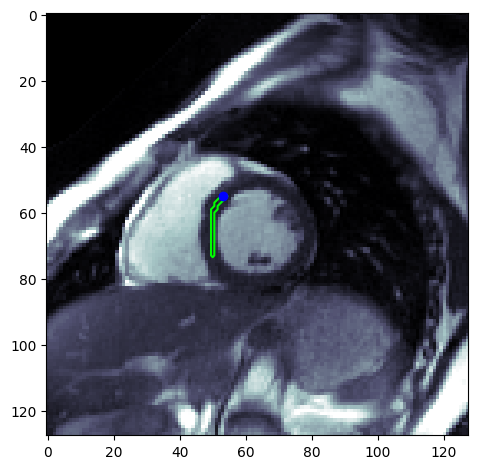

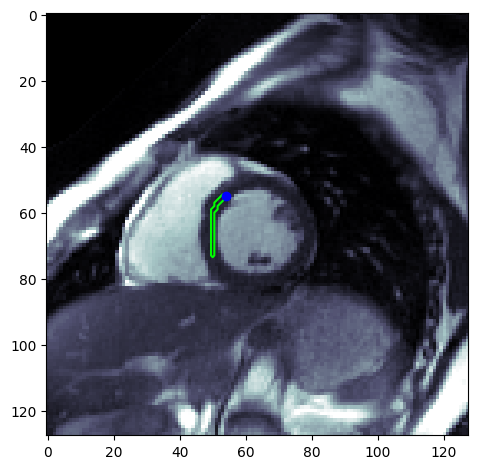

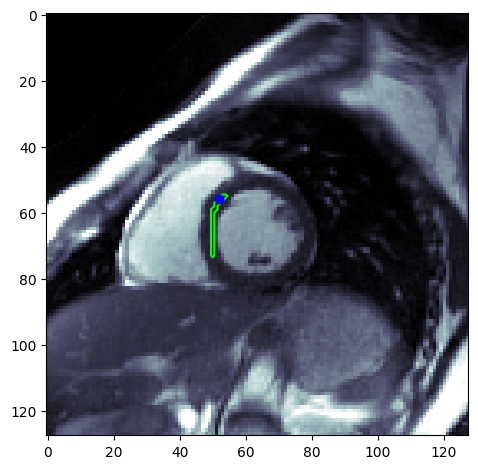

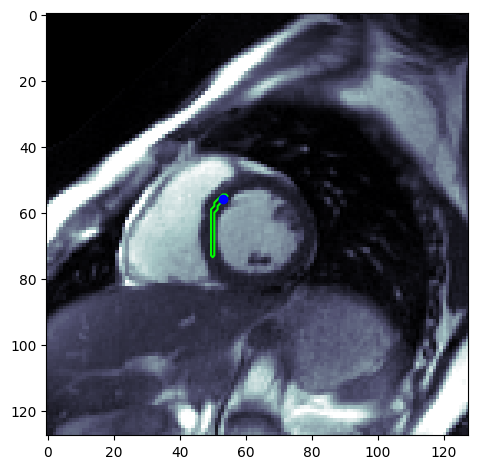

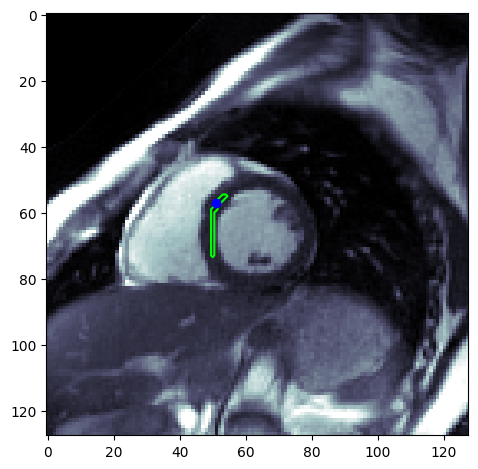

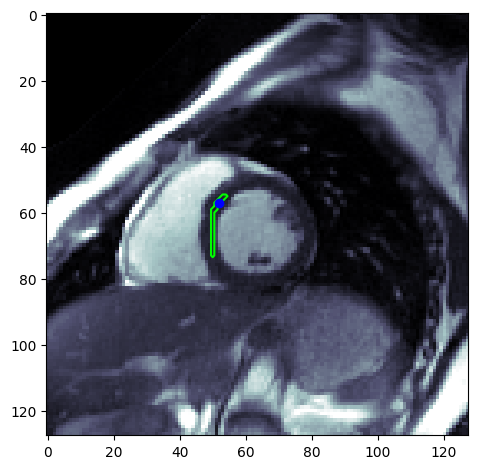

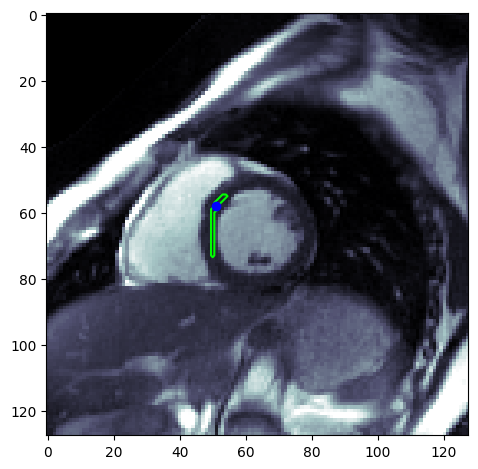

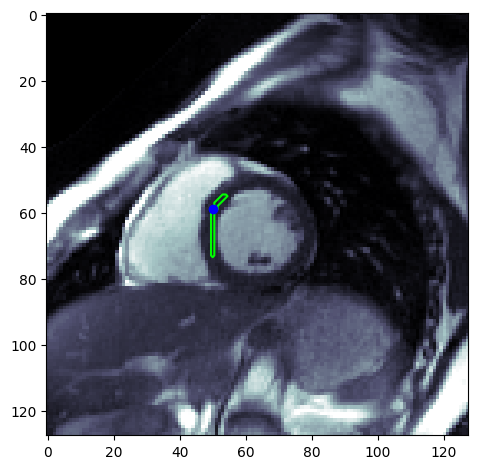

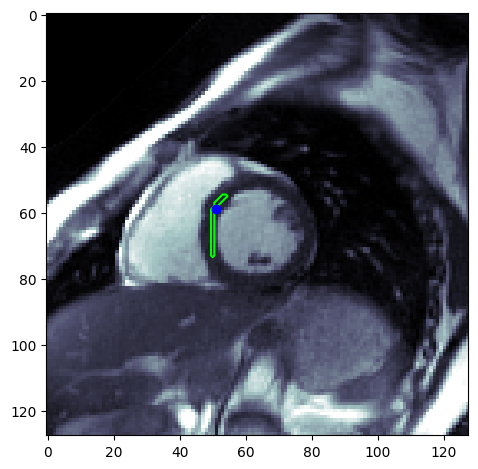

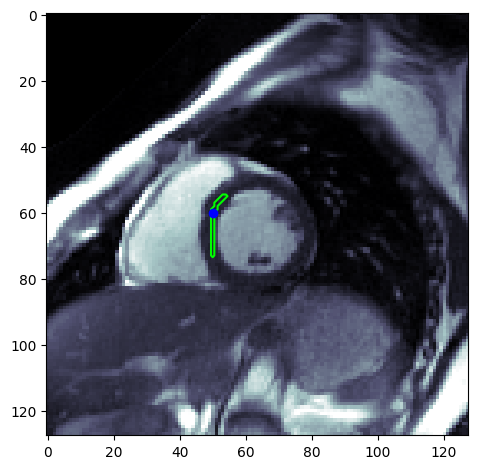

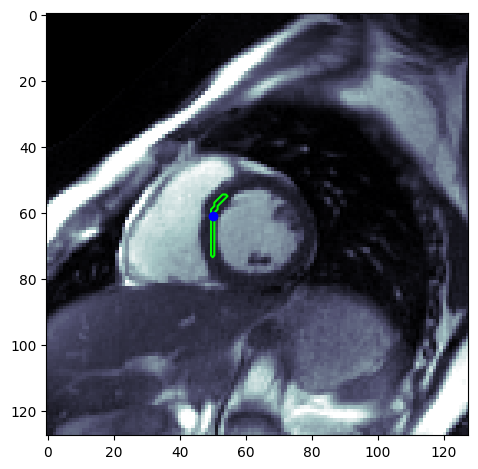

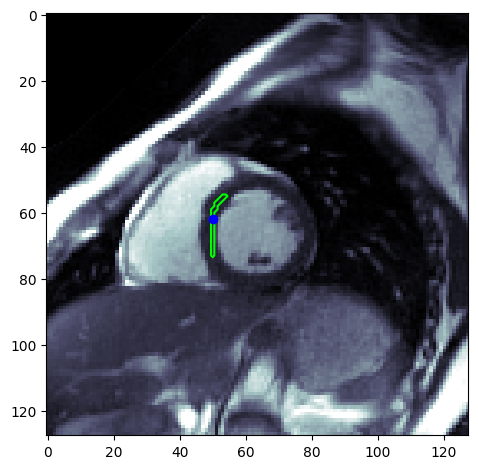

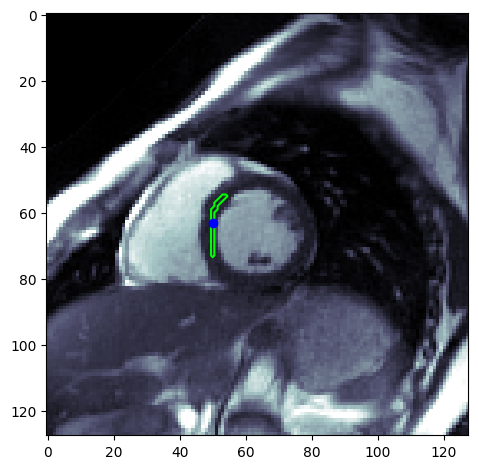

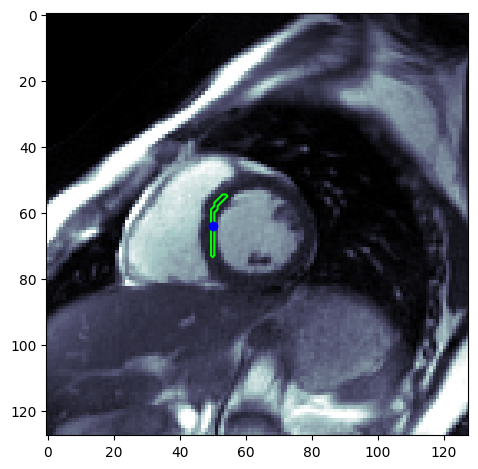

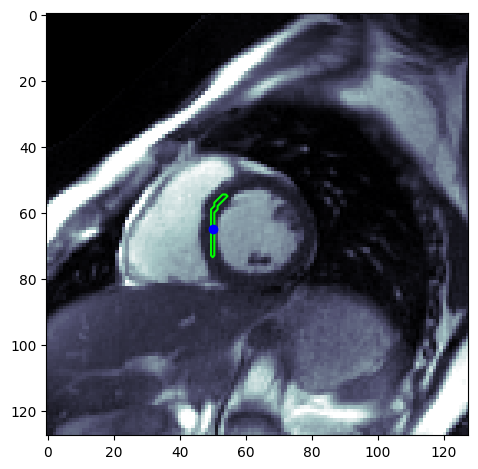

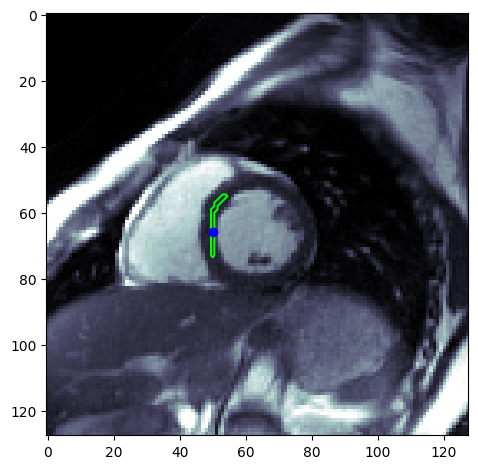

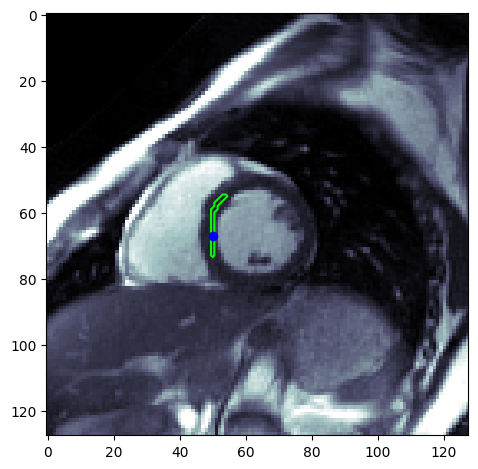

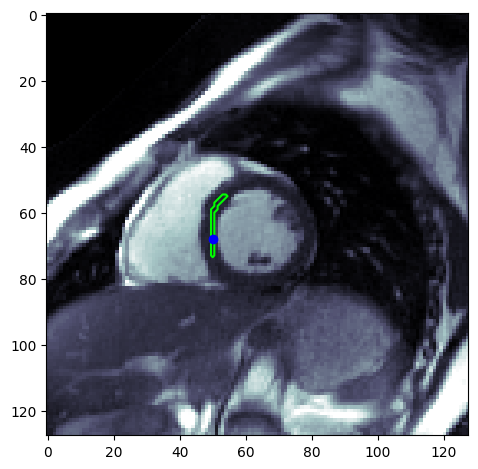

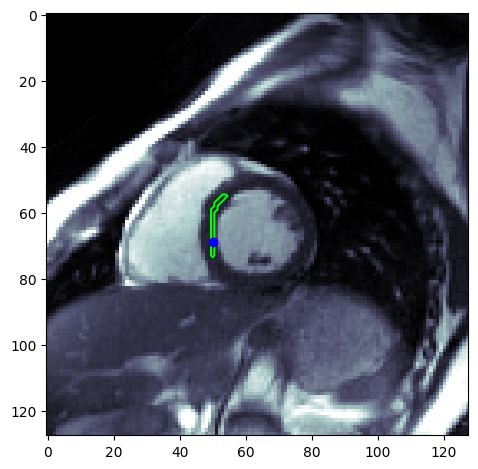

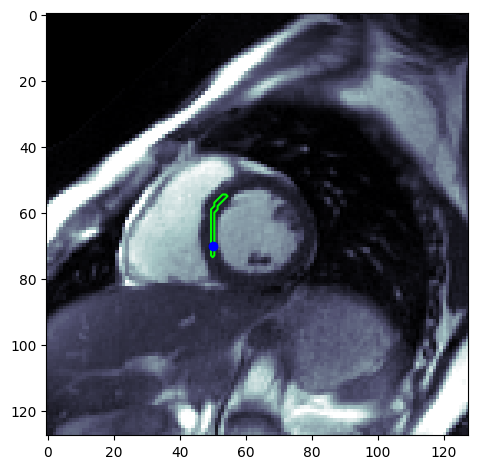

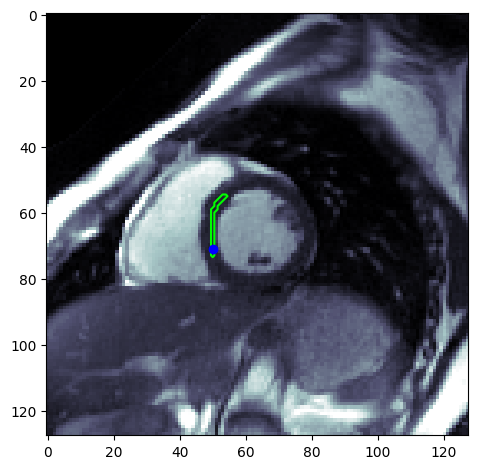

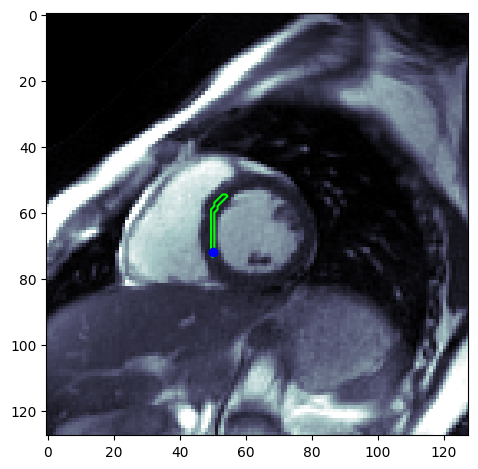

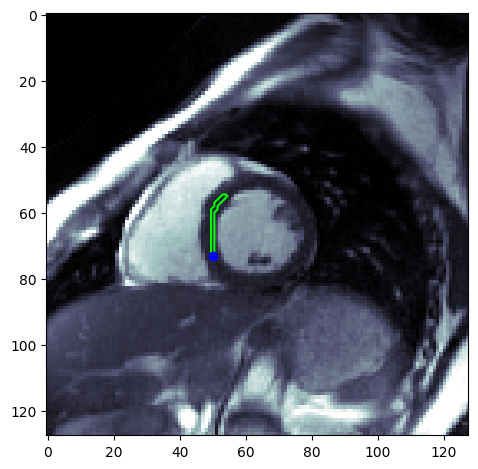

In [13]:
for i in range(  len(all_dict['cx'][0])  ):
    plt.imshow(np.clip(recon[:, :, 0], 0, vmax), cmap='bone', vmin=0, vmax=vmax)
    plt.contour(slice_data['segmentation']['fs']['sep'][:, :, 0], levels=[0.5], colors='lime', linewidths=1.5)
    plt.plot(all_dict['cx'][0][i], all_dict['cy'][0][i], 'bo', markersize=6)
    
    plt.tight_layout()
    plt.show()

# 2 .- Draw lines and get profiles

In [14]:
from inrmri.image_processor import crop_2d_im 
from inrmri.sharpness import (
    radial_sharpness,
    extract_line_at_points,
    get_line_points_from_angle,
    find_percentile_idx, 
    get_distance
)

In [33]:
import numpy as np
from scipy.ndimage import map_coordinates

def get_line_points(p1, p2, num=100):
    """
    Get equally spaced points between p1 and p2.
    Args:
        p1: (x1, y1)
        p2: (x2, y2)
        num: number of points
    Returns:
        2 x N array with row coords and col coords
    """
    x_vals = np.linspace(p1[0], p2[0], num)
    y_vals = np.linspace(p1[1], p2[1], num)
    return np.vstack([x_vals, y_vals])

def sample_line_from_image(image, p1, p2, num=100):
    """
    Sample image intensity along a line between two points.
    Args:
        image: 2D numpy array
        p1, p2: (x, y) start and end coordinates (row, col)
        num: number of points along the line
    Returns:
        values: intensity values along the line
        coords: (2 x N) coordinates sampled
    """
    coords = get_line_points(p1, p2, num)
    values = map_coordinates(image, coords, order=1, mode='reflect')
    return values, coords

def plot_image_and_projection(image, coords, values, vmax=1.0, sigmoid_fit = False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Image with line
    ax1 = axes[0]
    ax1.imshow(np.clip(image, 0, vmax), cmap='bone', vmin=0, vmax=vmax)
    ax1.scatter(coords[1], coords[0], s=1, c='red')  # coords: (row, col) -> scatter(x=col, y=row)
    ax1.set_title("Image and Sampled Line")
    ax1.axis('off')

    # Projection
    ax2 = axes[1]
    ax2.plot(values)
    if sigmoid_fit:
        fitted, params, x_centered = fit_sigmoid(values)
        ax2.plot(values, 'b.', label='Profile')
        ax2.plot(fitted, 'r-', label='Fitted Sigmoid')
    else: 
        ax2.plot(values)
    ax2.set_title("Intensity Profile Along Line")
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("Intensity")

    plt.tight_layout()
    plt.show()

In [34]:
import math
def compute_distance_two_points_2d(point1,point2, bool_round=False):
    distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
    if bool_round:
        distance = round(distance)
    return distance

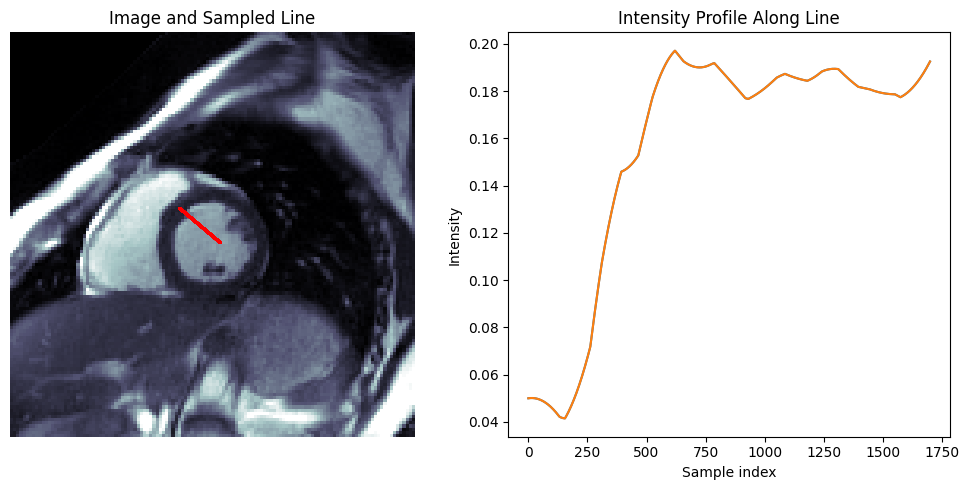

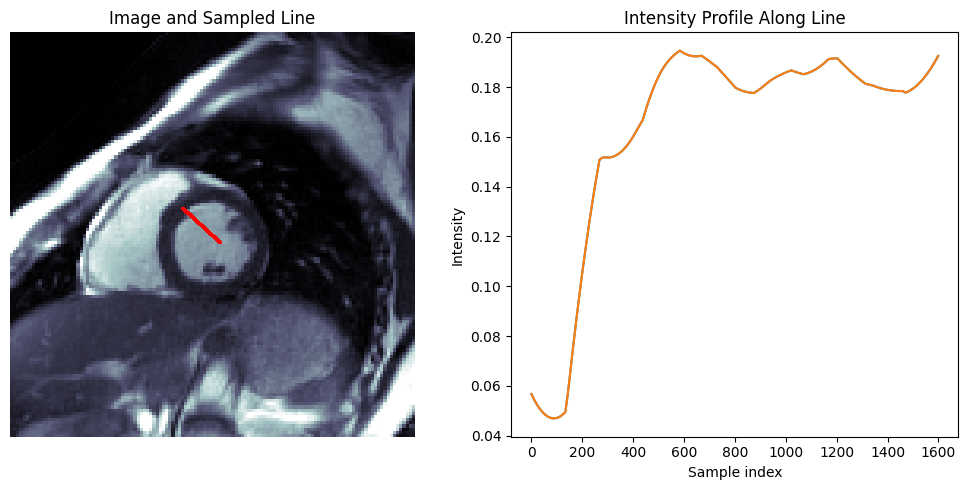

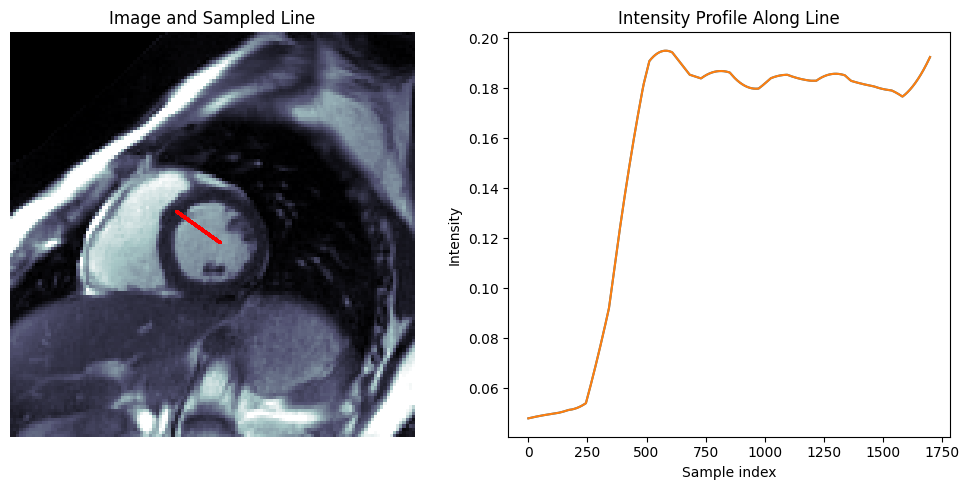

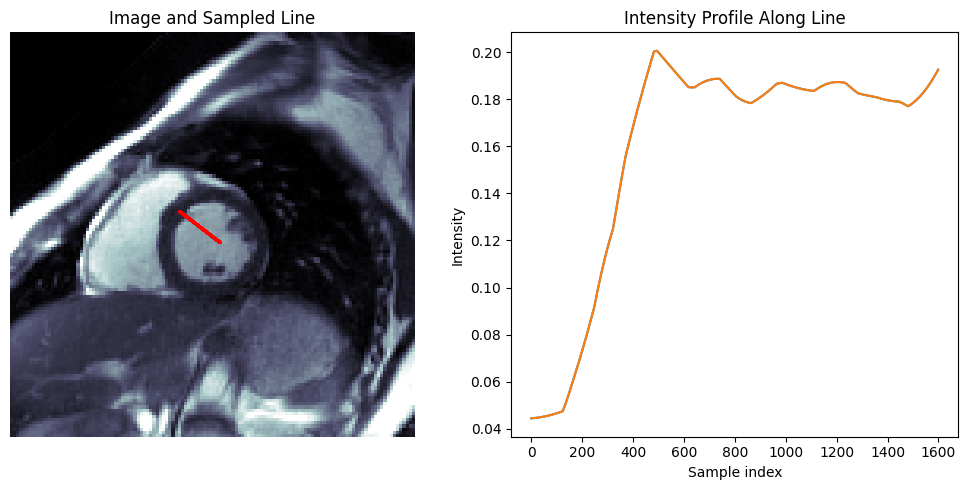

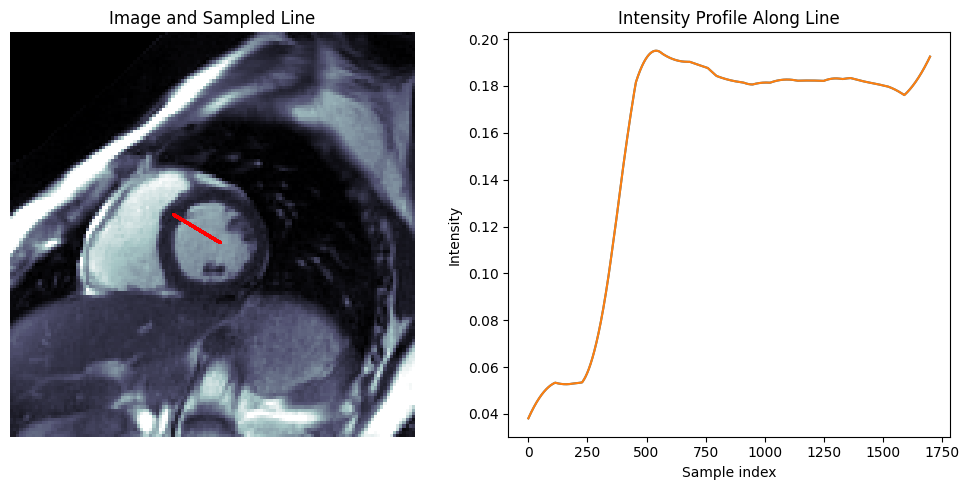

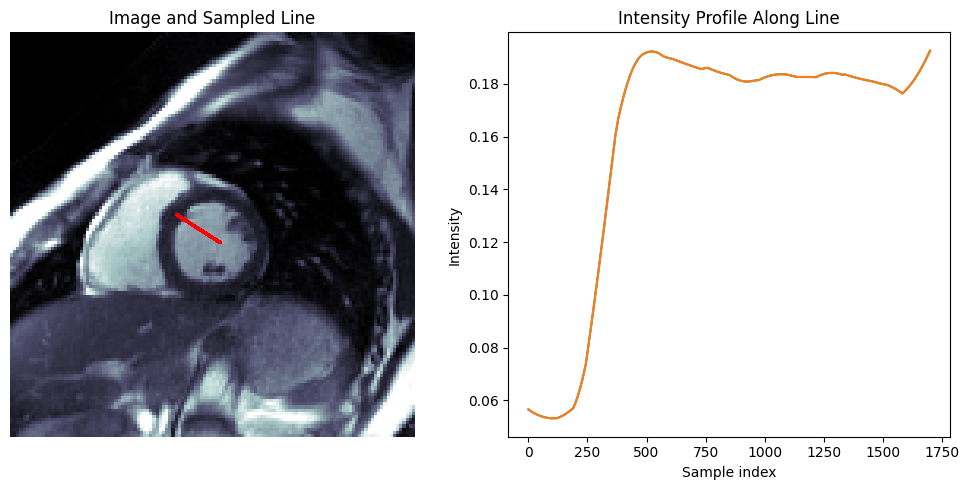

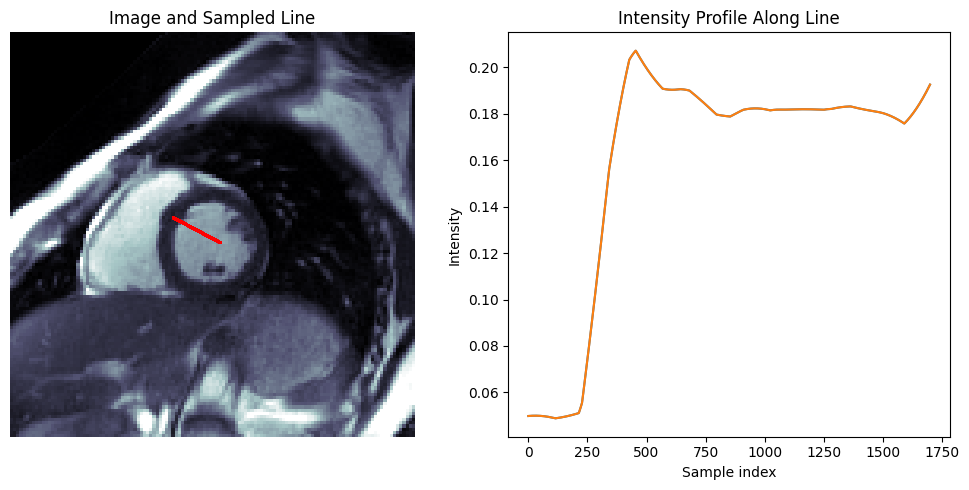

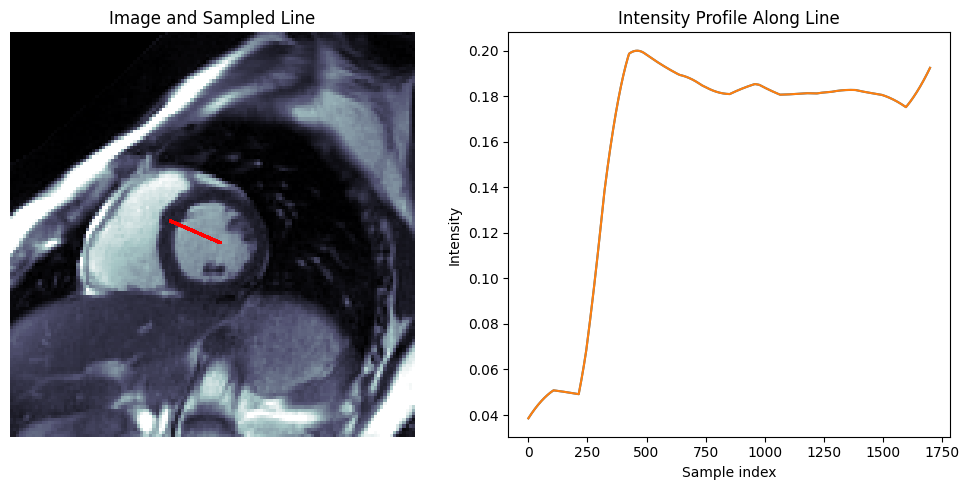

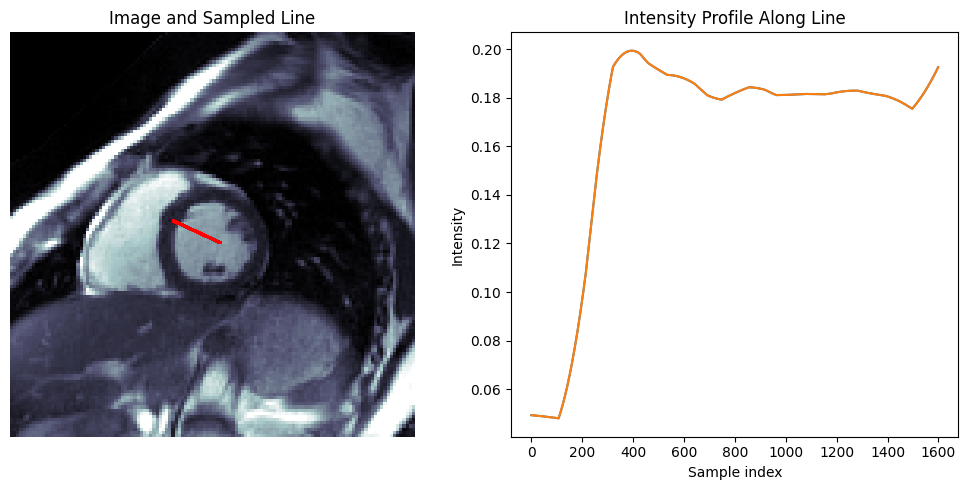

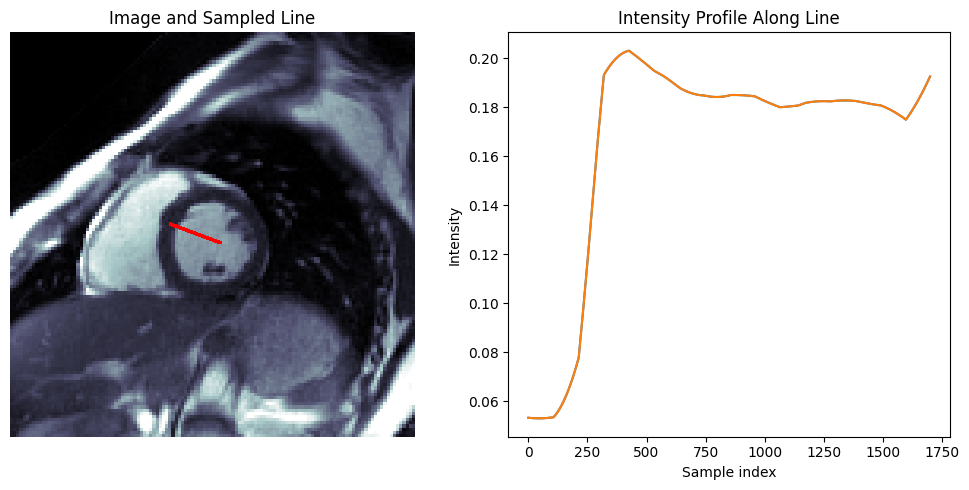

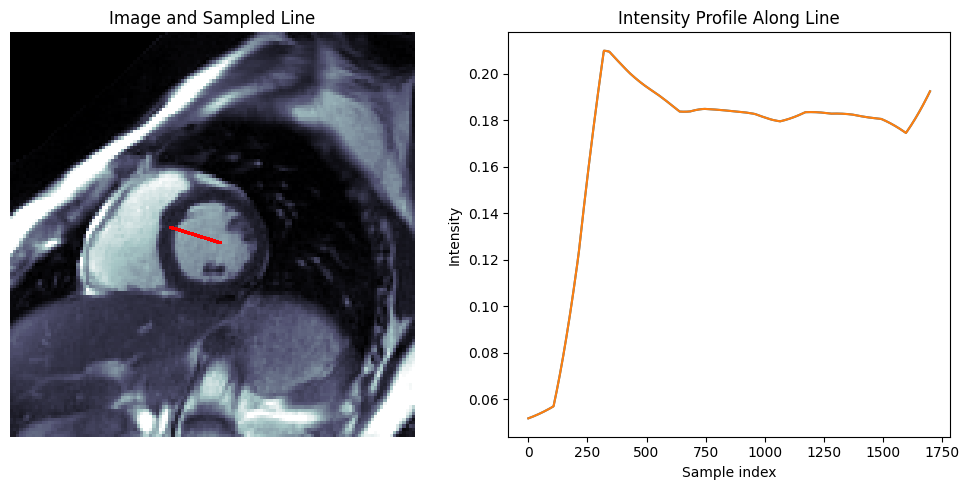

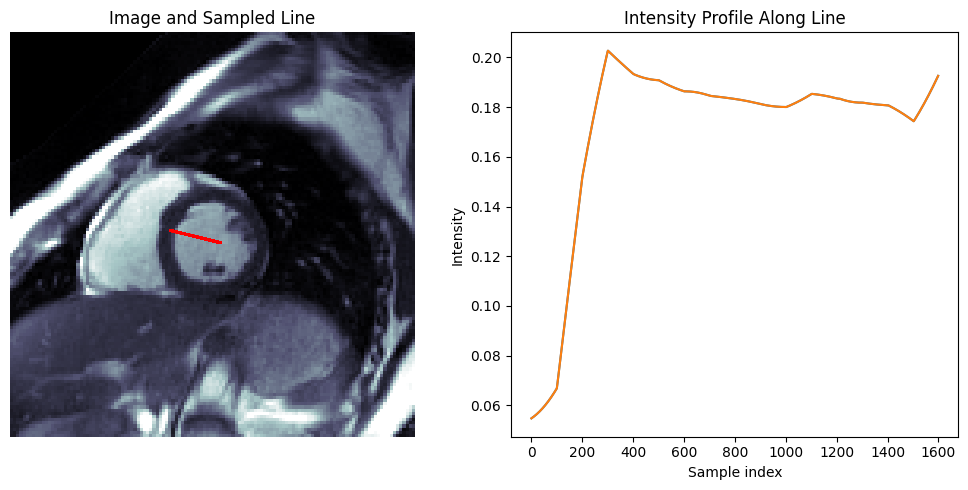

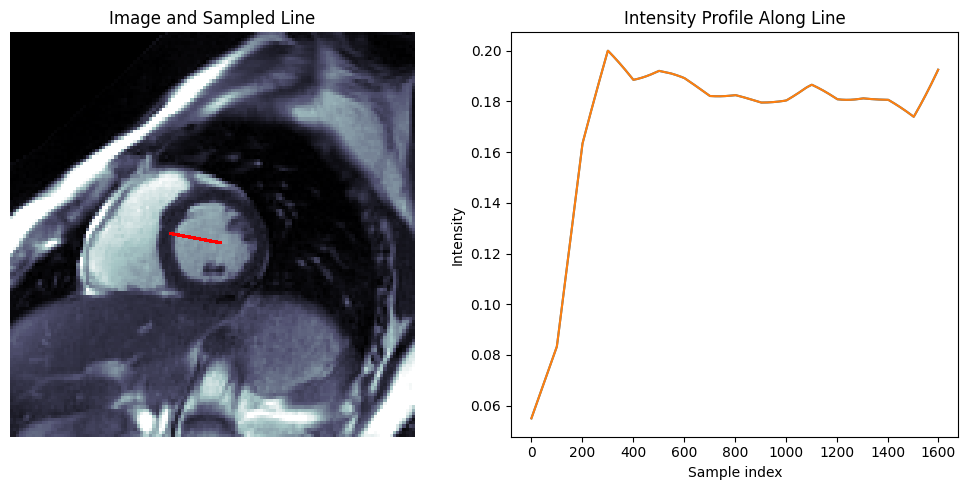

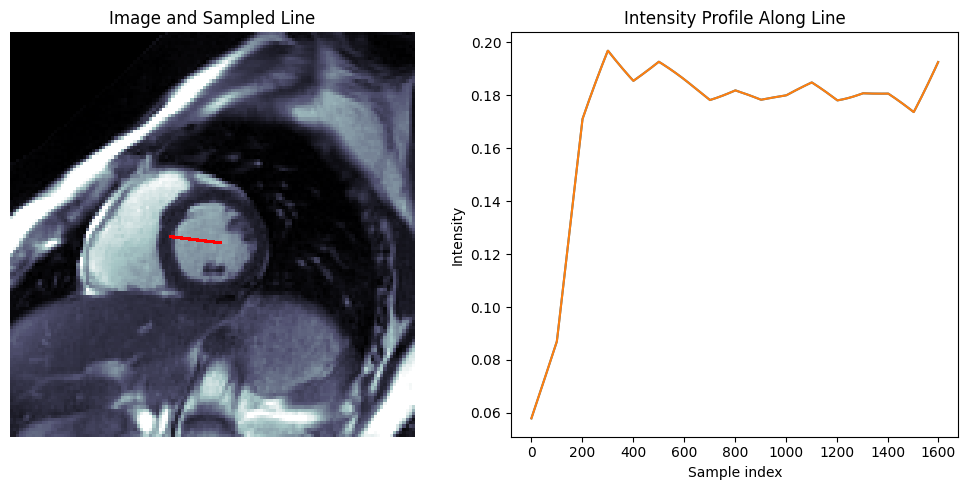

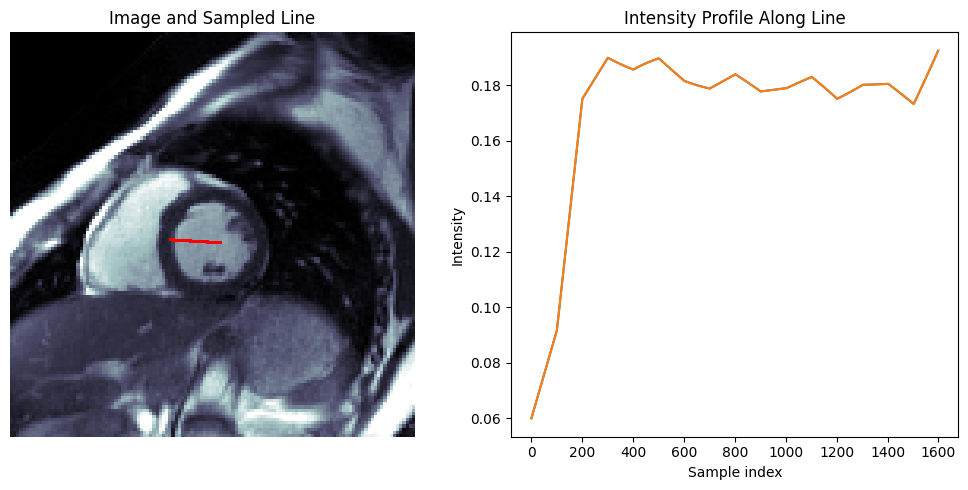

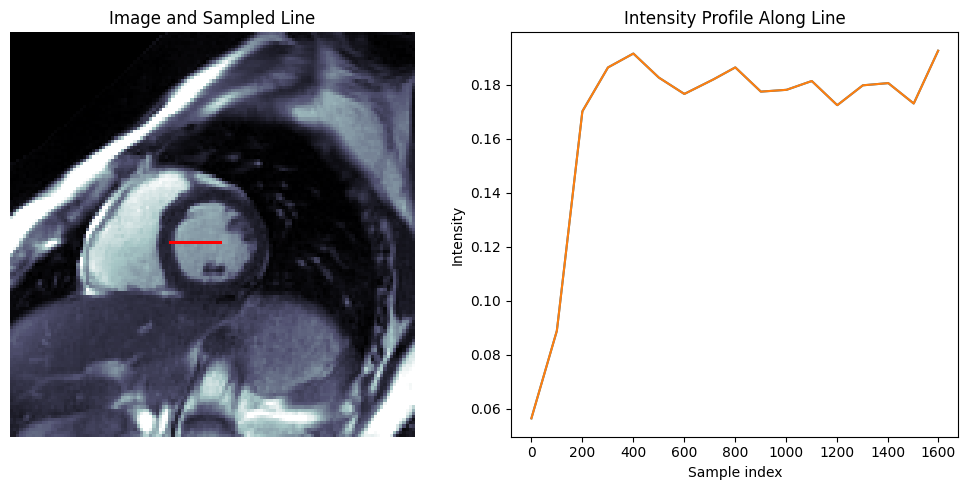

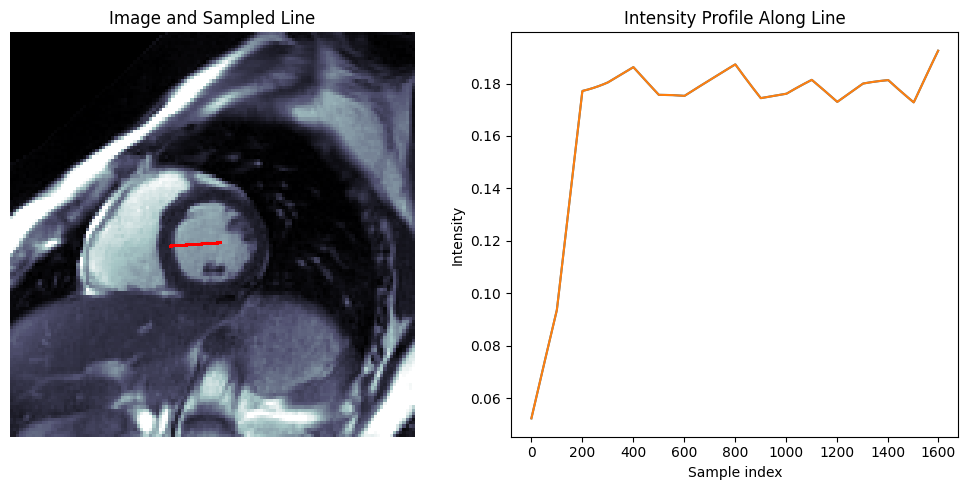

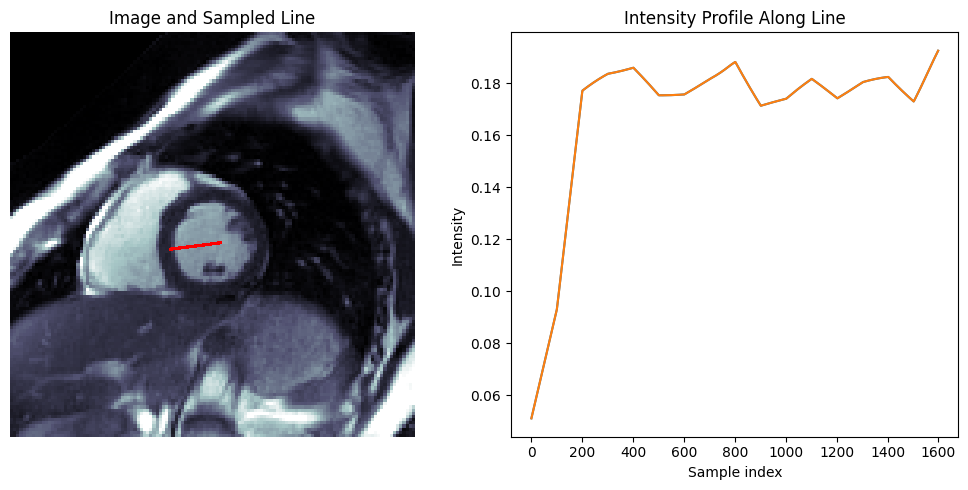

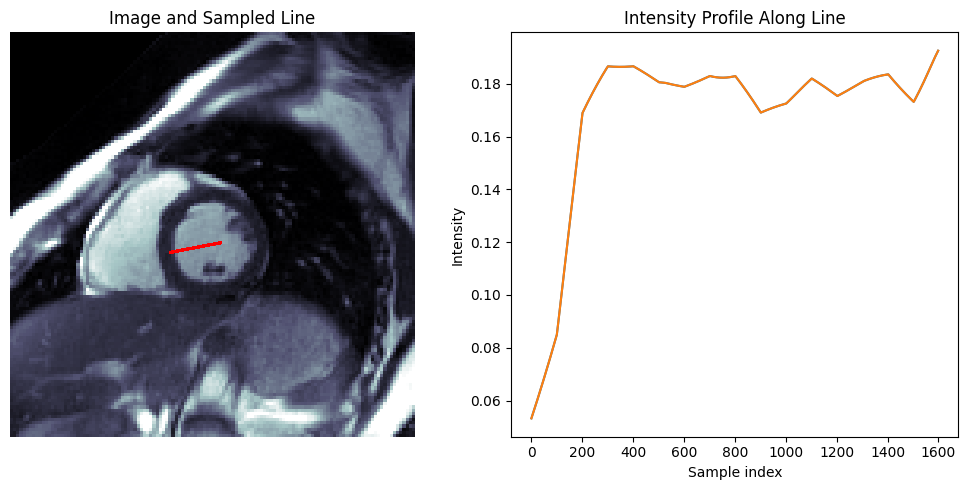

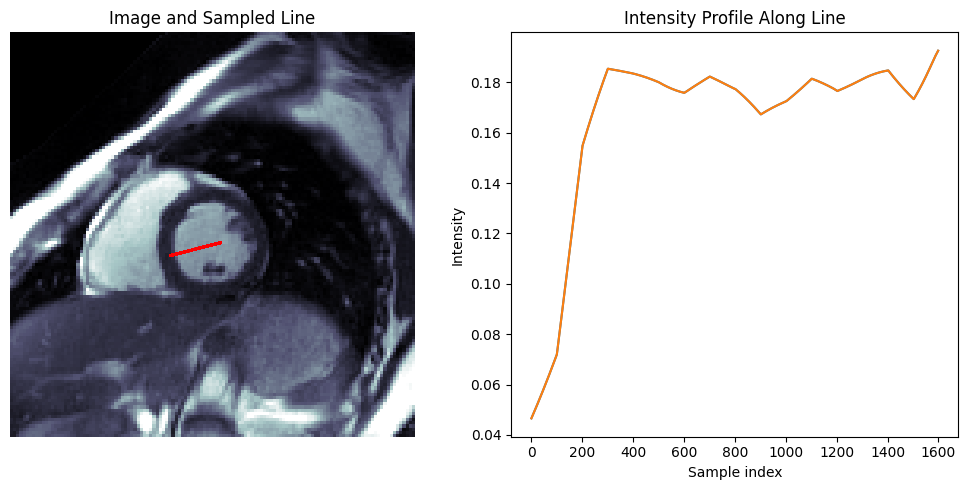

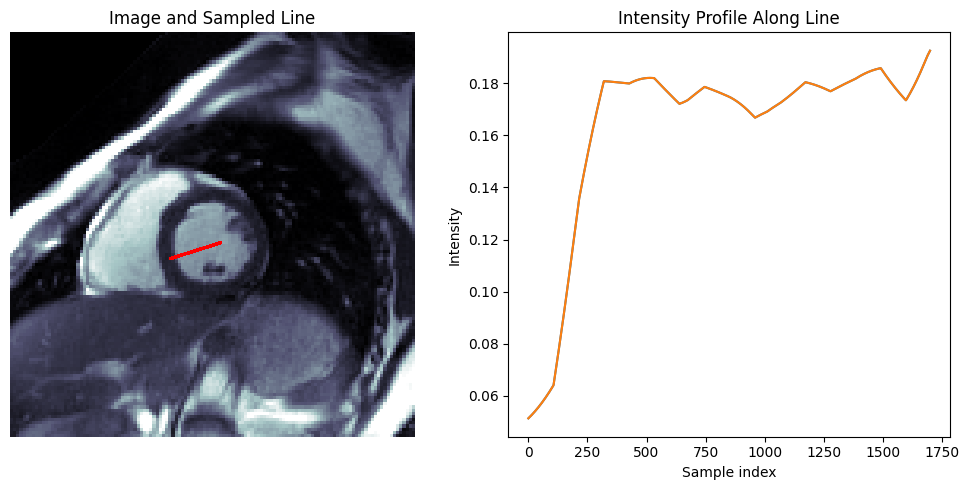

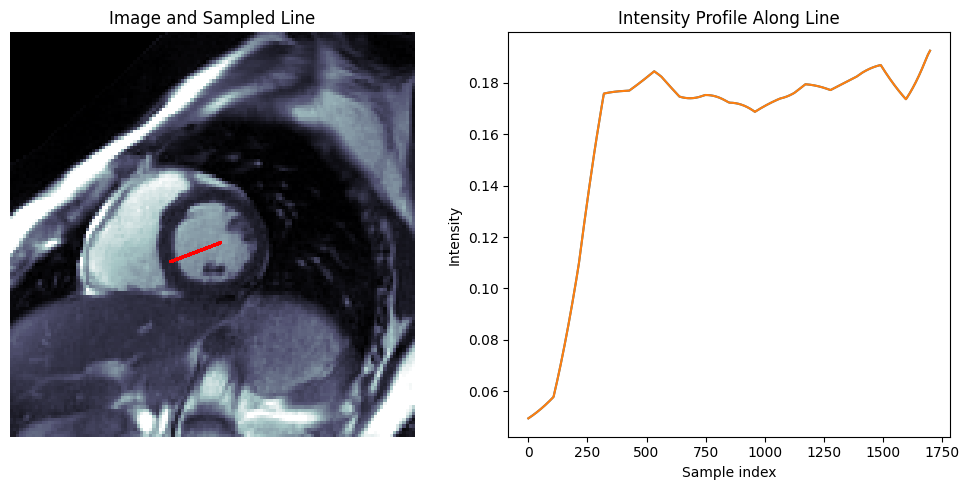

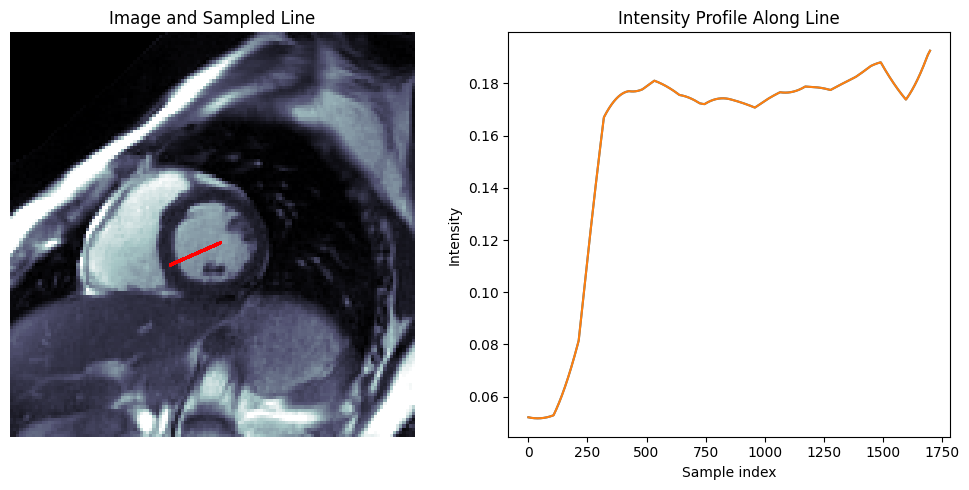

In [35]:
p2 = (centers_dict['cy'][0], centers_dict['cy'][0])
for i in range(  len(all_dict['cx'][0])  ):
    p1 = (all_dict['cy'][0][i], all_dict['cx'][0][i])
    values, coords = sample_line_from_image(recon[:,:,0], p1, p2, num=100*compute_distance_two_points_2d(p1, p2, bool_round=True))
    plot_image_and_projection(recon[:,:,0], coords, values, vmax=vmax)

# 3 .- Fit sigmoid to the profile

In [43]:
from scipy.optimize import curve_fit
import numpy as np

def safe_sigmoid(x, L, x0, k, b):
    z = -k * (x - x0)
    z = np.clip(z, -500, 500)
    return L / (1 + np.exp(z)) + b

def fit_sigmoid(profile):
    y = np.asarray(profile)
    mean_val = np.mean(y)
    closest_idx = np.argmin(np.abs(y - mean_val))
    x_centered = np.arange(len(y)) - closest_idx

    p0 = [np.max(y) - np.min(y), 0, 0.1, np.min(y)]  # small k to start
    bounds = ([0, -np.inf, -10, -np.inf], [np.inf, np.inf, 10, np.inf])  # limit steepness

    try:
        popt, _ = curve_fit(
            safe_sigmoid, x_centered, y, p0,
            method='trf', maxfev=10000, bounds=bounds
        )
        fitted_profile = safe_sigmoid(x_centered, *popt)
        return fitted_profile, popt, x_centered
    except RuntimeError:
        print("Sigmoid fit did not converge.")
        return None, None, x_centered


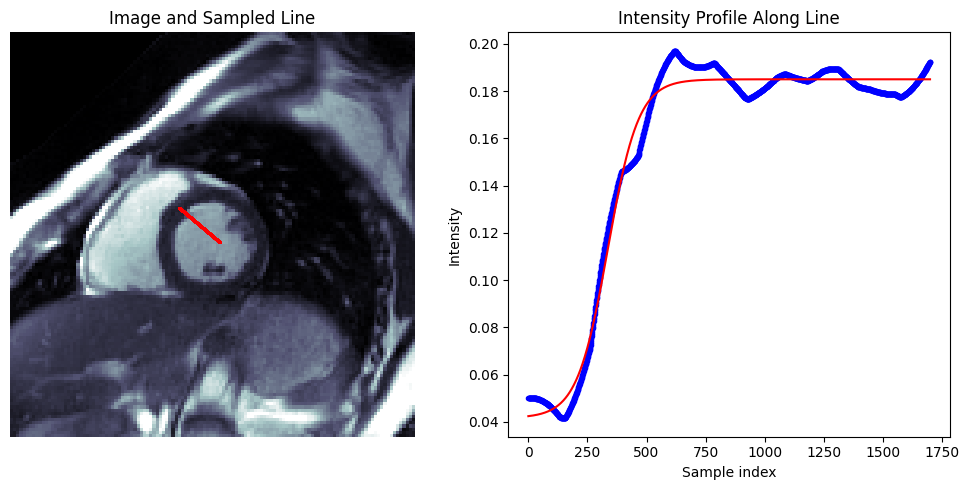

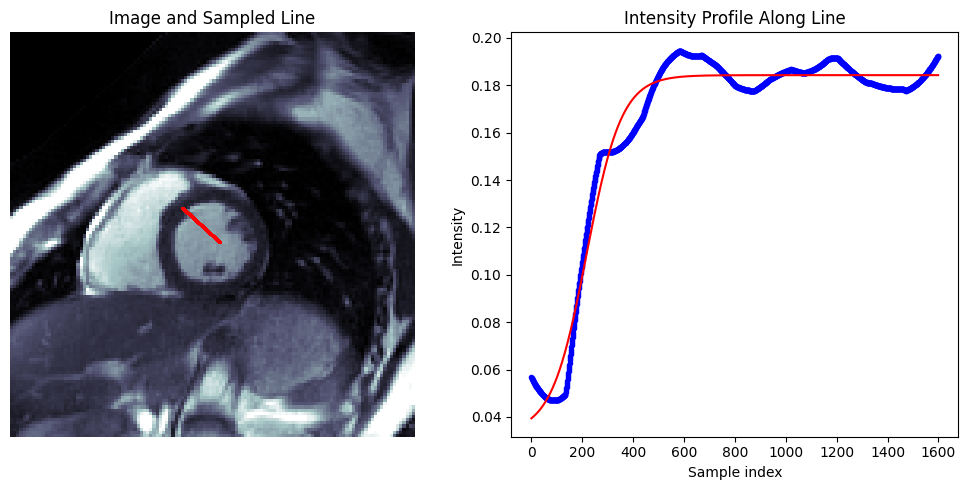

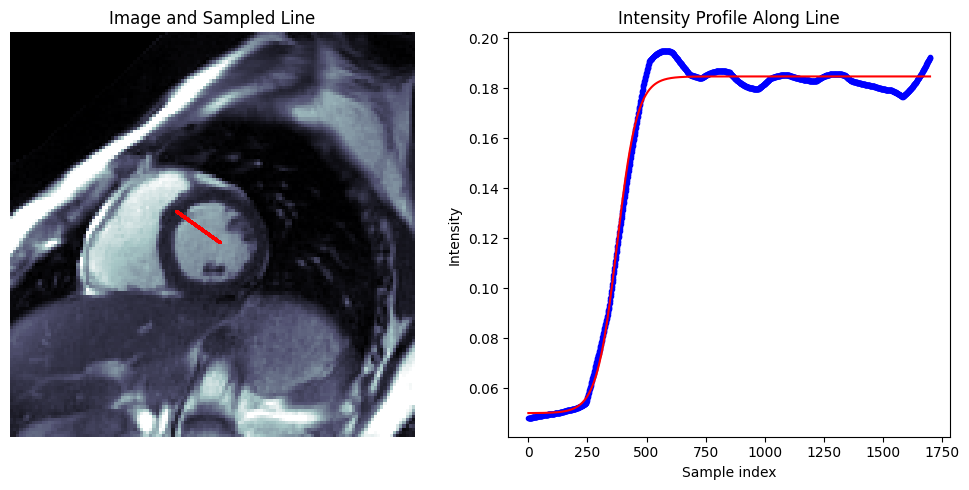

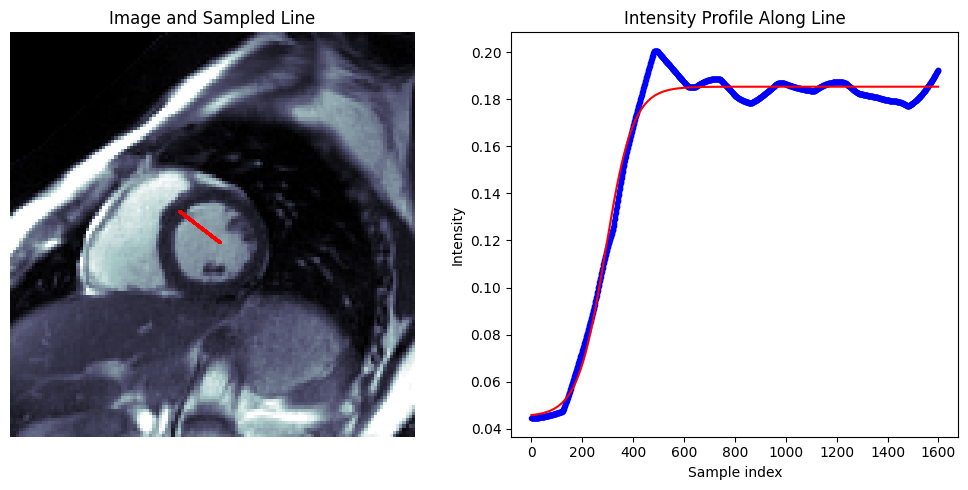

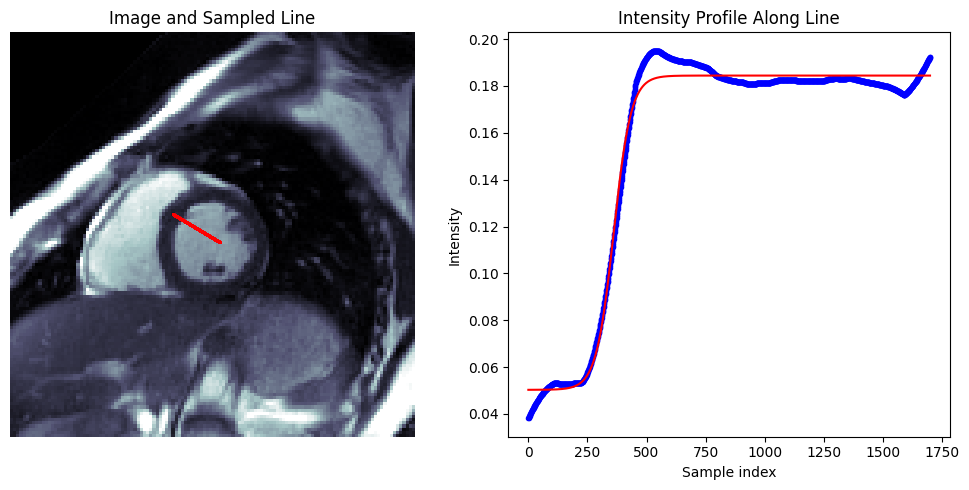

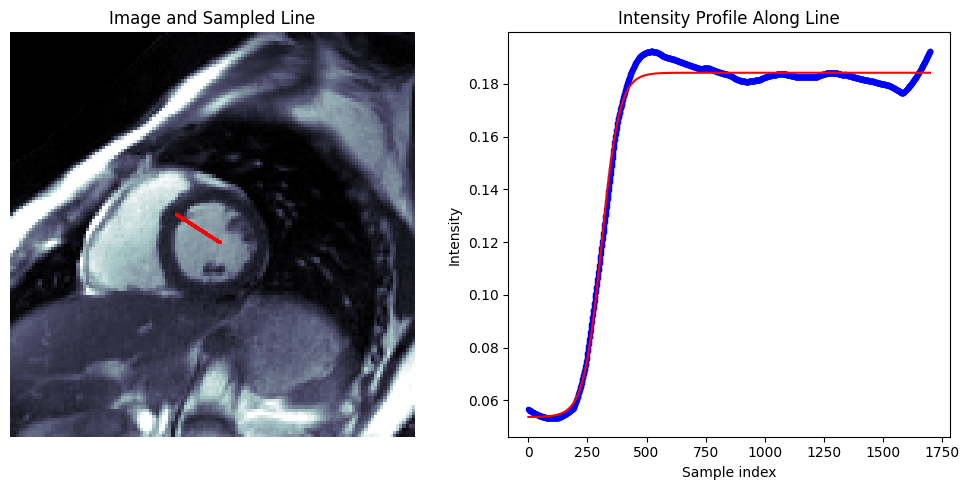

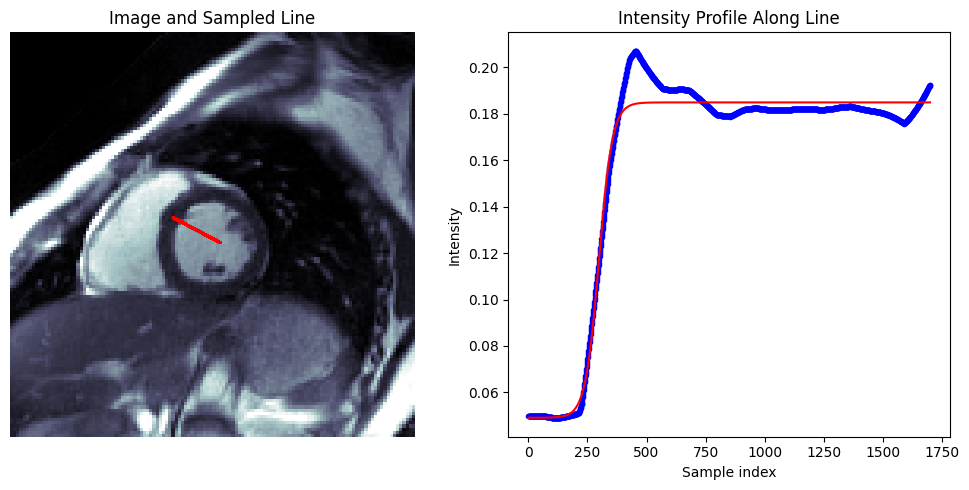

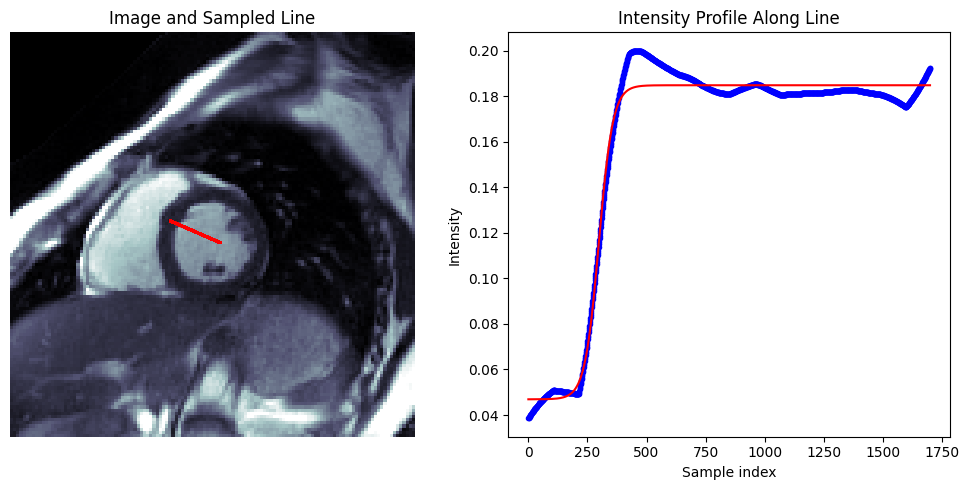

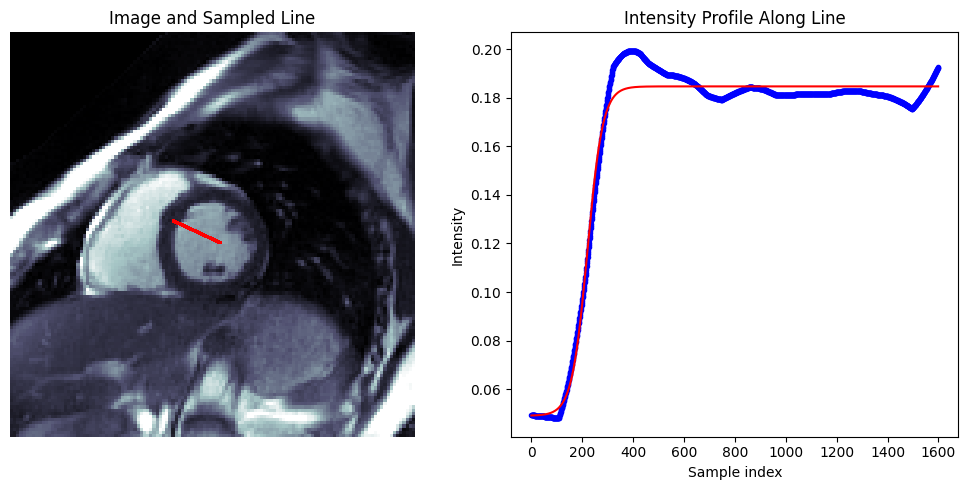

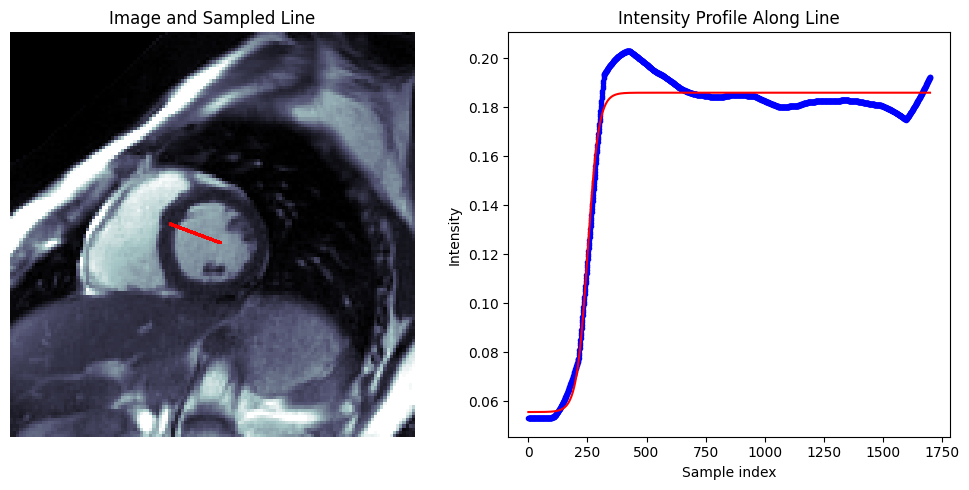

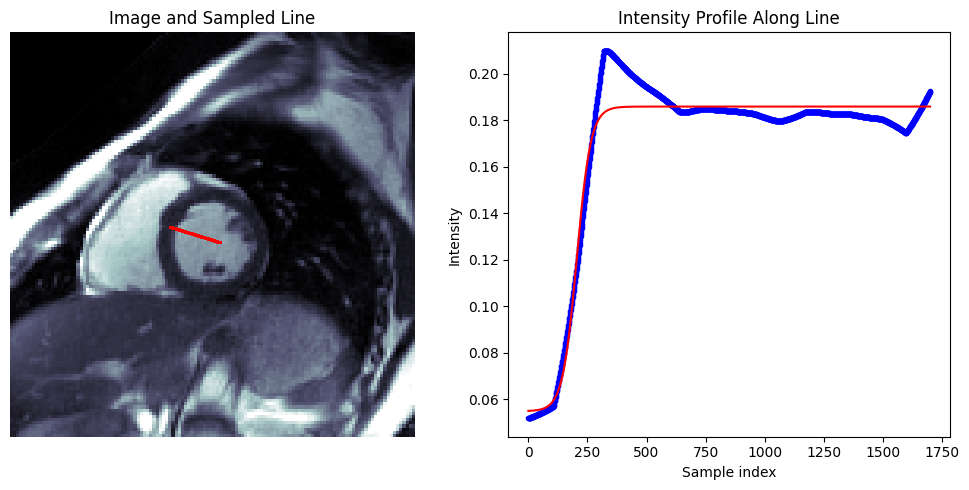

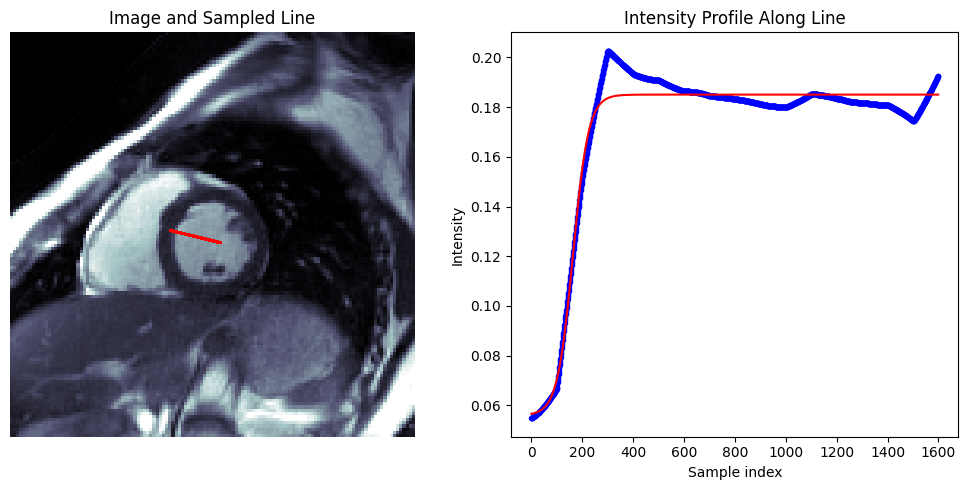

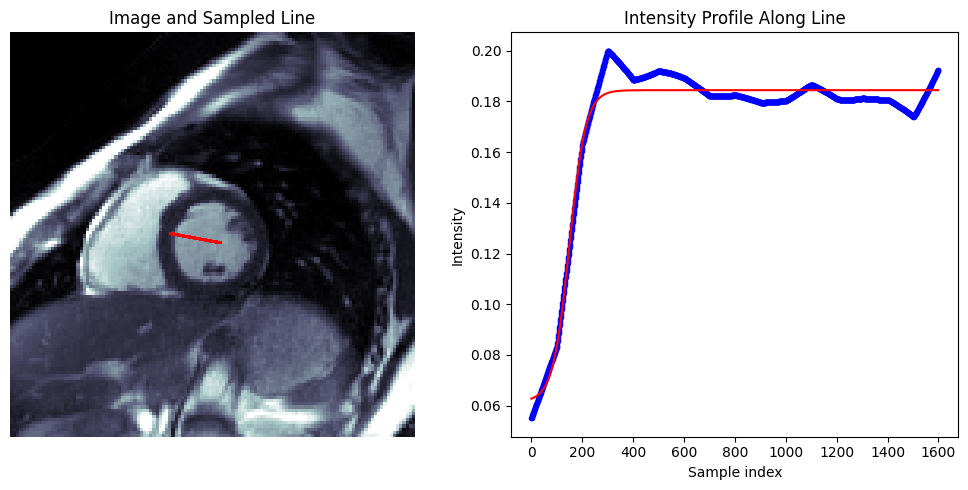

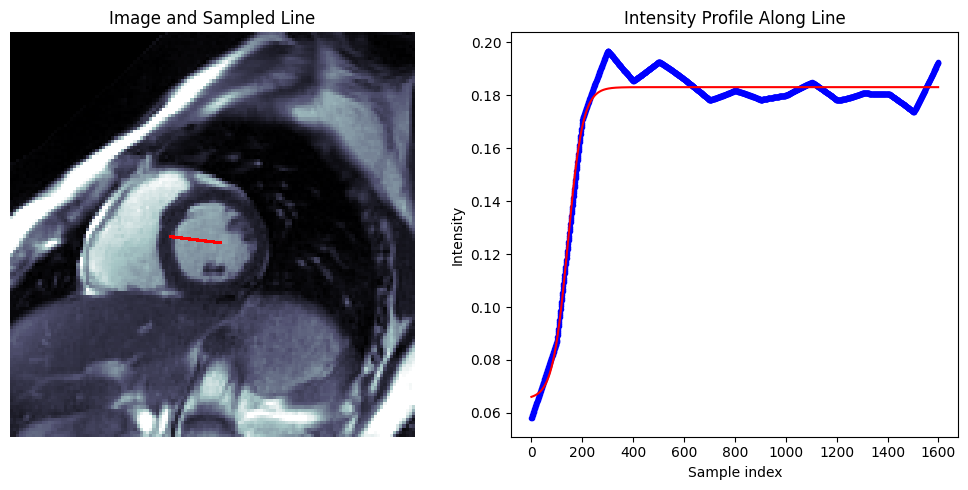

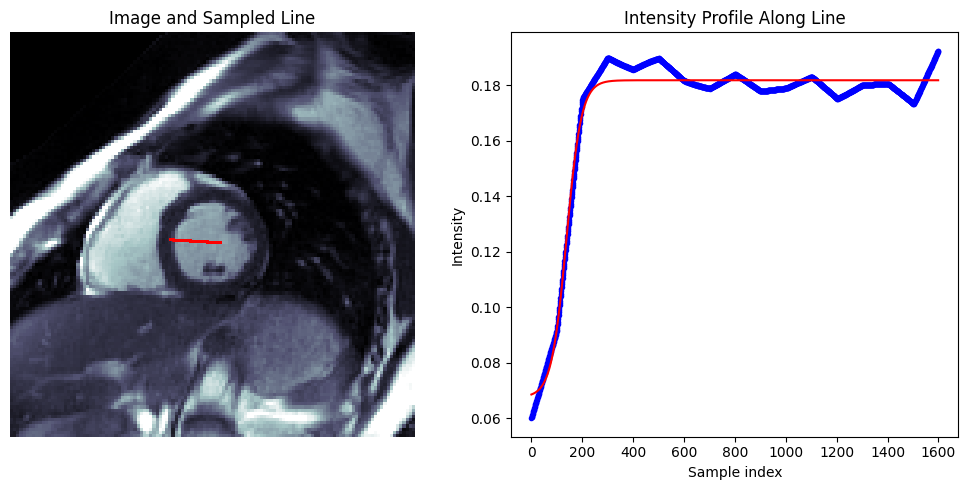

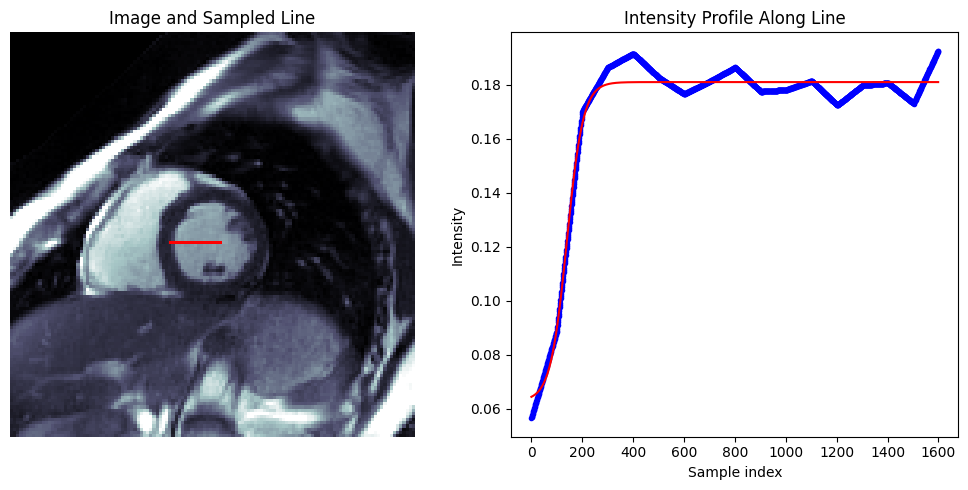

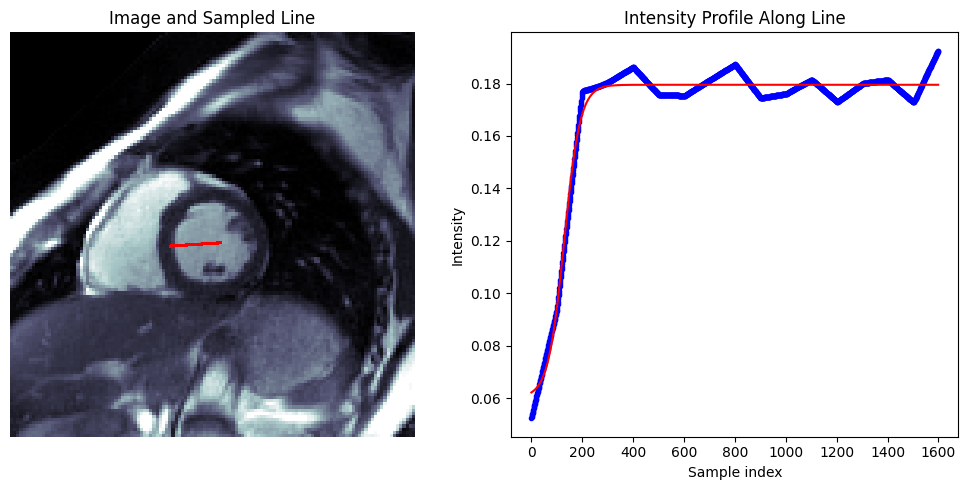

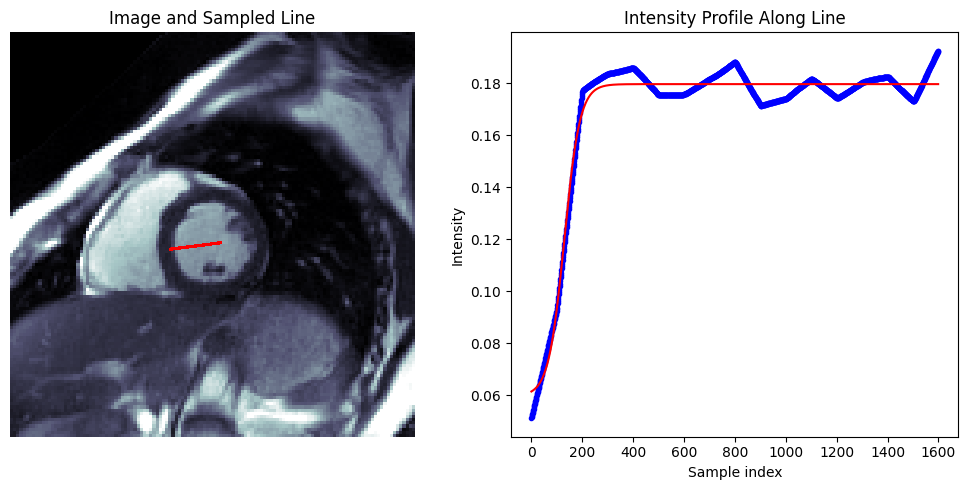

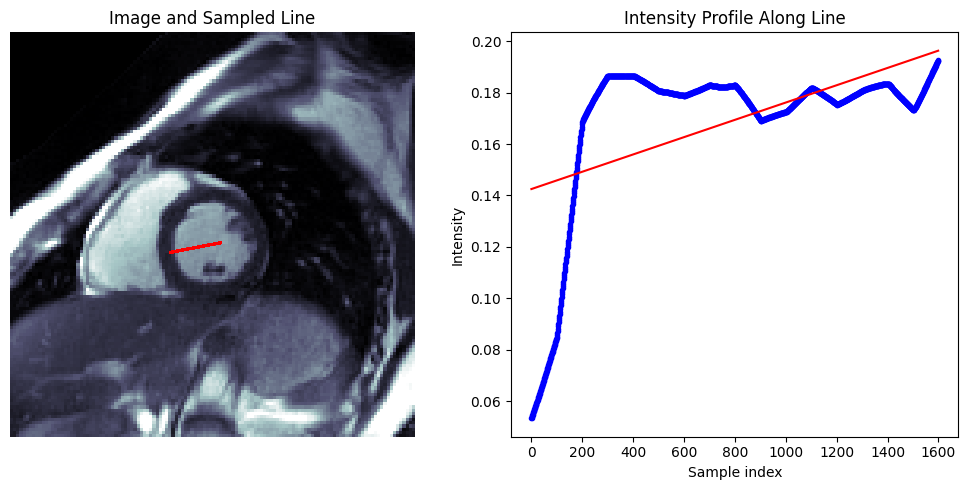

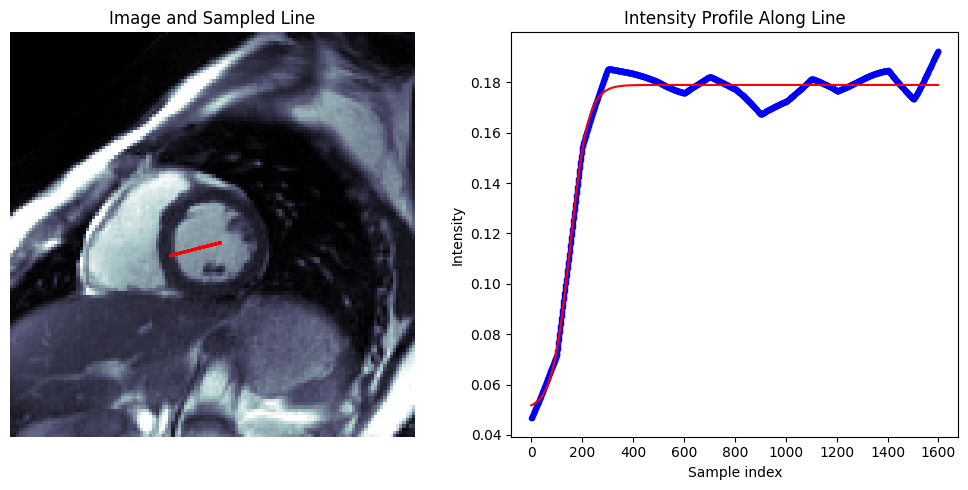

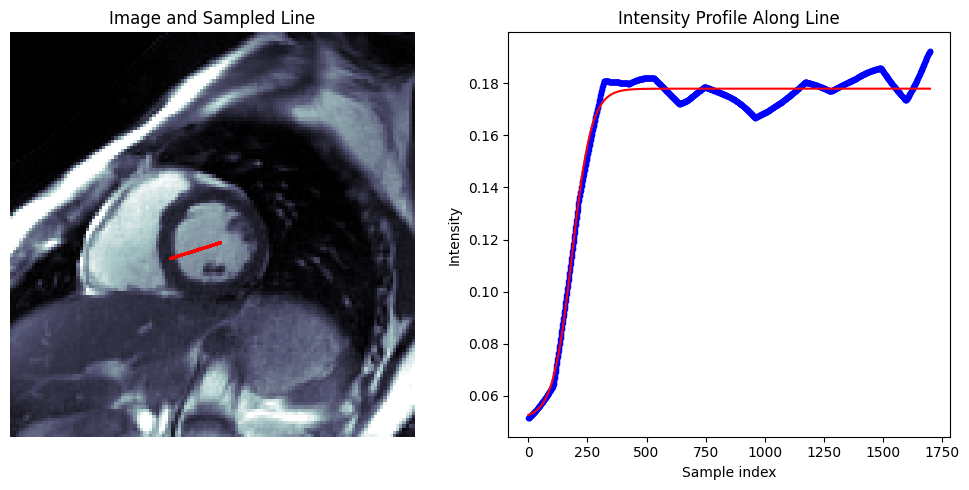

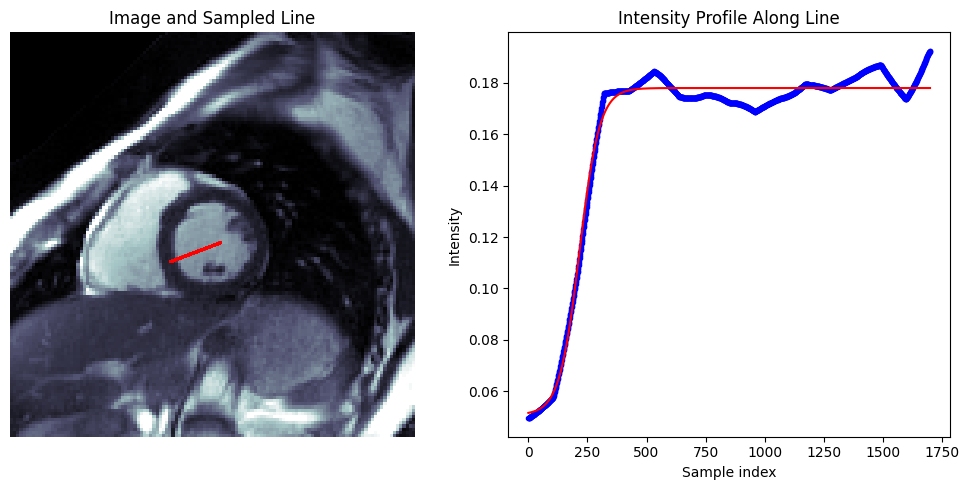

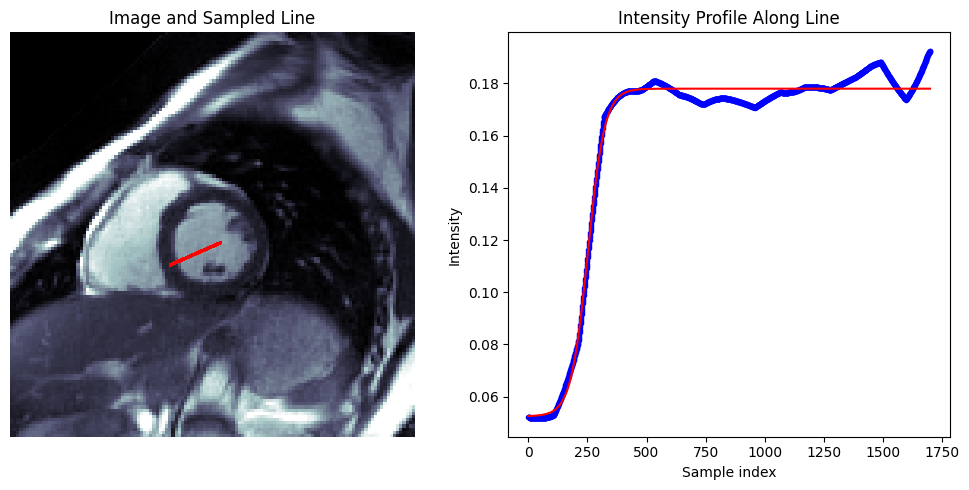

In [44]:
p2 = (centers_dict['cy'][0], centers_dict['cy'][0])
for i in range(  len(all_dict['cx'][0])  ):
    p1 = (all_dict['cy'][0][i], all_dict['cx'][0][i])
    values, coords = sample_line_from_image(recon[:,:,0], p1, p2, num=100*compute_distance_two_points_2d(p1, p2, bool_round=True))
    plot_image_and_projection(recon[:,:,0], coords, values, vmax=vmax, sigmoid_fit = True)

# 4 .- Get 20 80 statistics per line

In [47]:
def compute_20_80_statistics(values, coords):
    # find_percentile_idx funciona en un vector ordenado y entrega el indice más
    # cercano al valor min + (max-min)*p/100, con p=20 y 80
    idx_sorting   = np.argsort(values)
    idx_sorted_20, p20 = find_percentile_idx(values[idx_sorting], 20) 
    idx_sorted_80, p80 = find_percentile_idx(values[idx_sorting], 80) 
    
    # encontrar los índeces del vector original 
    corrected_idxs = np.arange(values.shape[0])[idx_sorting]
    idx_20 = corrected_idxs[idx_sorted_20]
    idx_80 = corrected_idxs[idx_sorted_80]
    
    # get_distance(points) es 1 si los puntos están en horizontal o vertical 
    # pero es mayor cuando los puntos están en diagonal
    d_20_80 = np.abs(idx_20 - idx_80) 
    d       = d_20_80 * get_distance(coords.T)
    dict_20_80_statistics = {
        'p20':p20,
        'p80':p80,
        'idx_20':idx_20,
        'idx_80':idx_80,
        'd_20_80':d_20_80,
        'd':d,
    }
    return dict_20_80_statistics

def plot_20_80_statistics(values, dict_20_80_statistics):
    p20     = dict_20_80_statistics['p20']
    p80     = dict_20_80_statistics['p80']
    idx_20  = dict_20_80_statistics['idx_20']
    idx_80  = dict_20_80_statistics['idx_80']
    d_20_80 = dict_20_80_statistics['d_20_80']
    d       = dict_20_80_statistics['d']
    
    plt.plot(values, '.-', color = 'red', label= 'profile')
    
    p20_color = 'orange'
    plt.hlines([p20], xmin=0, xmax=14, color=p20_color, label='p20', linestyles=(0,(1,3)))
    plt.vlines([idx_20], ymin=values.min(), ymax=values.max(), color=p20_color, label='idx_20', linestyles=(0,(1,1)))
    
    p80_color = 'blue'
    plt.hlines([p80], xmin=0, xmax=14, color=p80_color, label='p80', linestyles=(0, (3,3,1,3)))
    plt.vlines([idx_80], ymin=values.min(), ymax=values.max(), color=p80_color, label='idx_80', linestyles=(0, (3,1,1,1)))
    
    plt.hlines([values.min()], xmin=idx_20, xmax=idx_80, color='gray', linestyles='-')
    plt.text(x=(idx_20 + idx_80)/2, y=values.min() + 0.07 * (values.max() - values.min()), s='$d_{20, 80} = $' + f'{d_20_80}', ha='center', va='center', color='gray')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('$d_{20,80} = ' f'{d_20_80}$, sharpness 1/d {1 / d:.3f}')
    plt.tight_layout()
    plt.show()

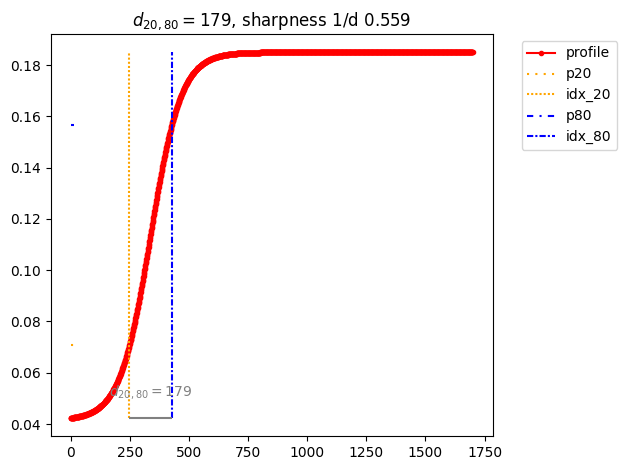

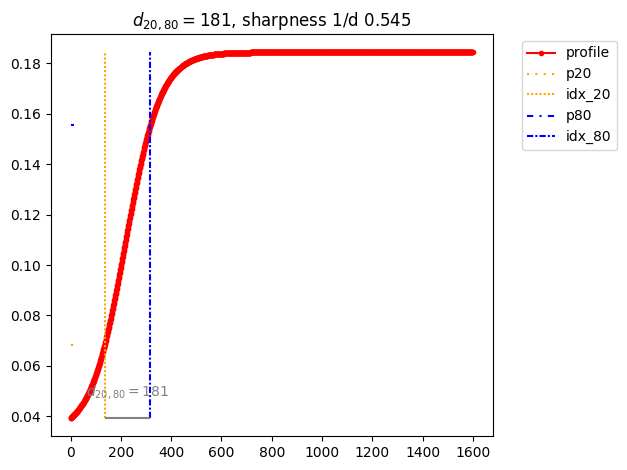

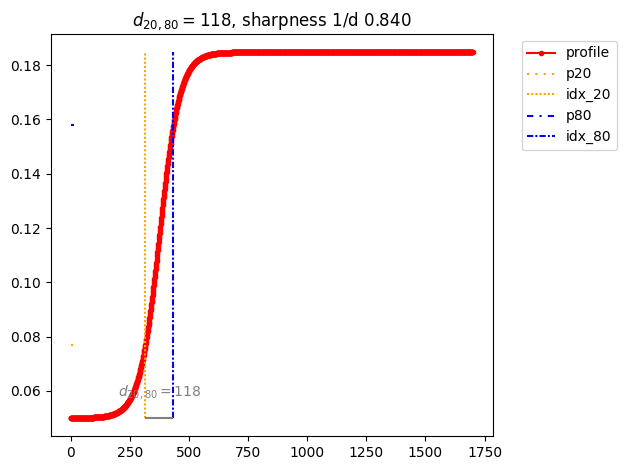

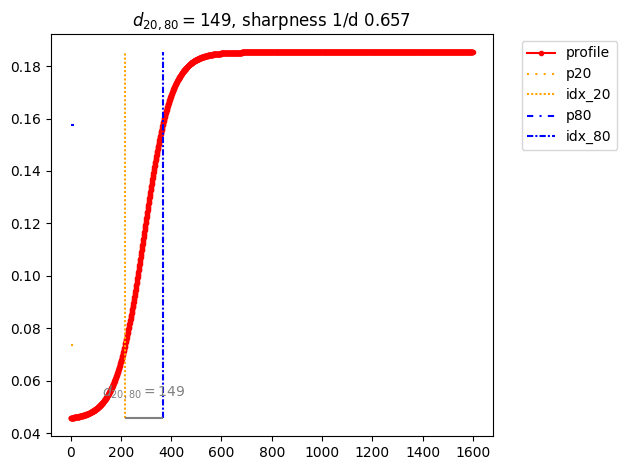

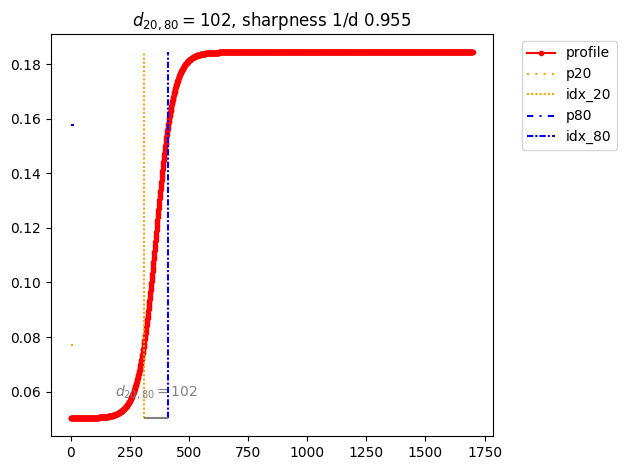

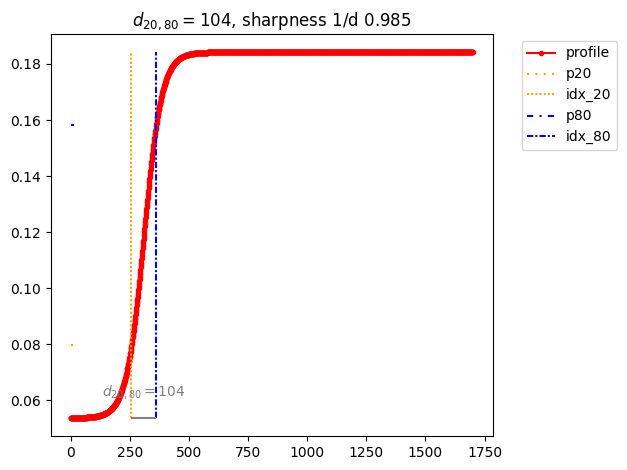

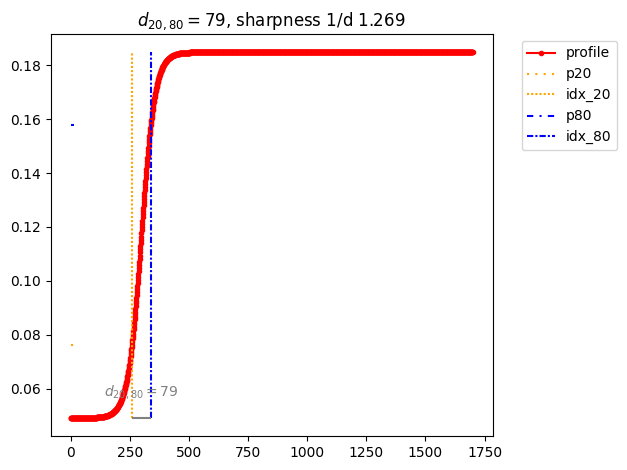

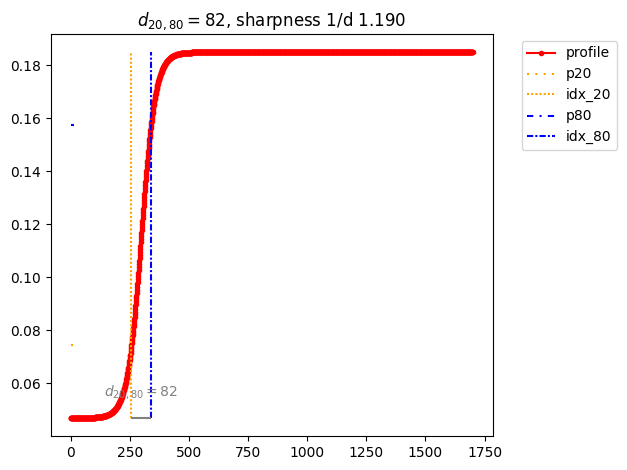

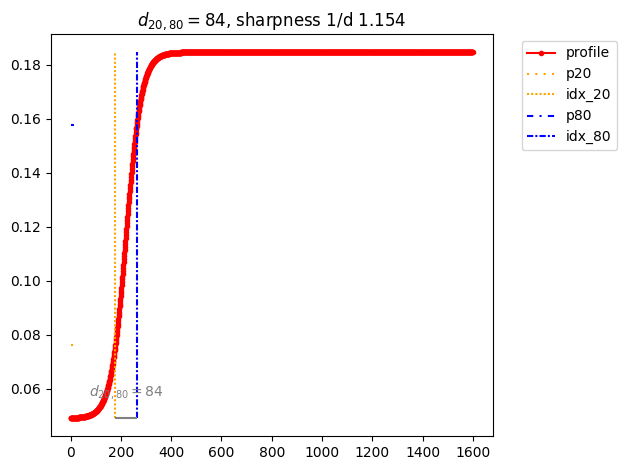

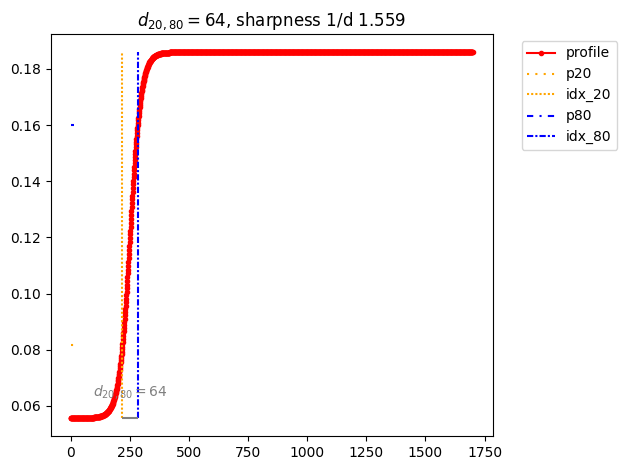

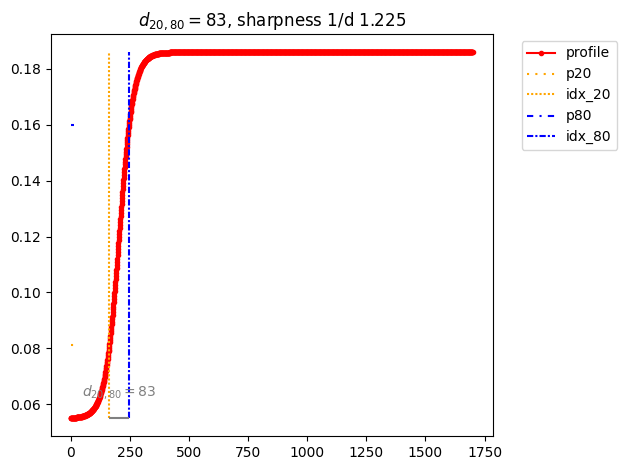

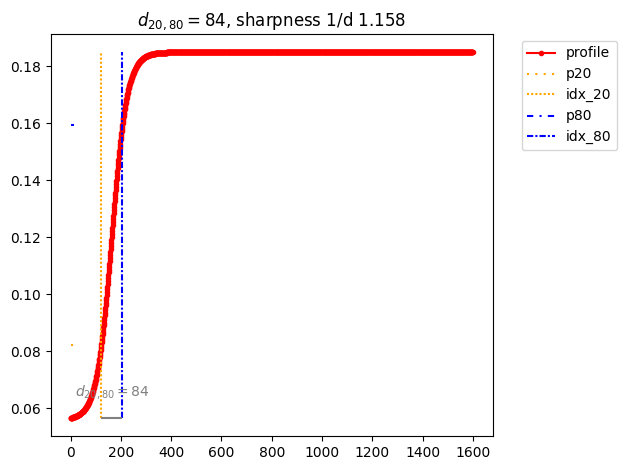

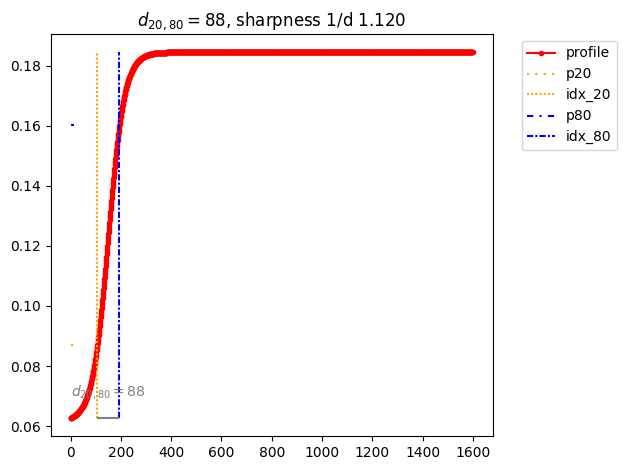

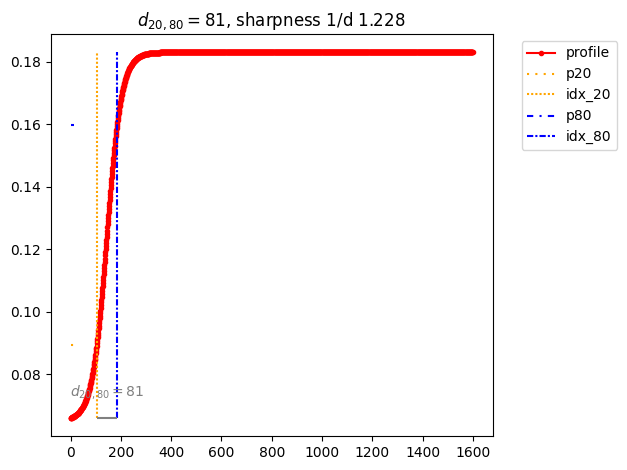

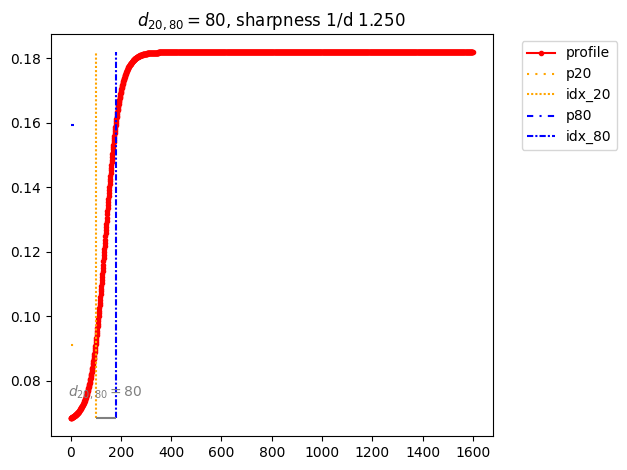

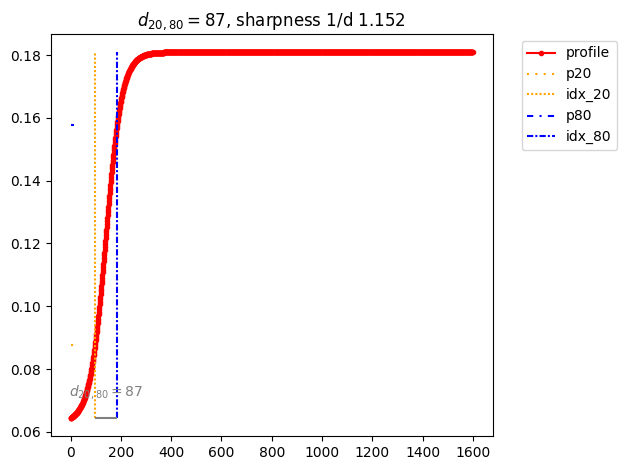

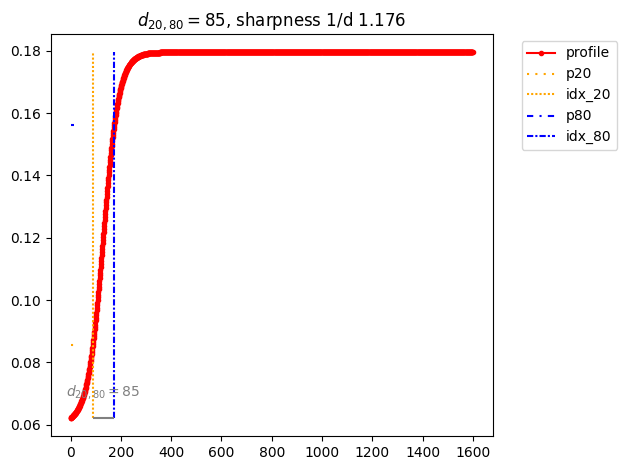

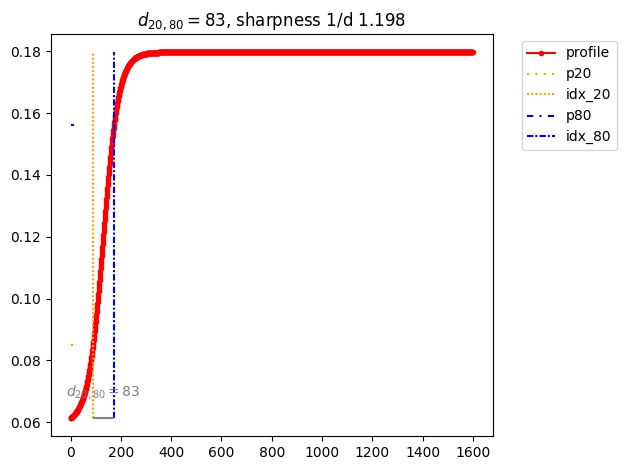

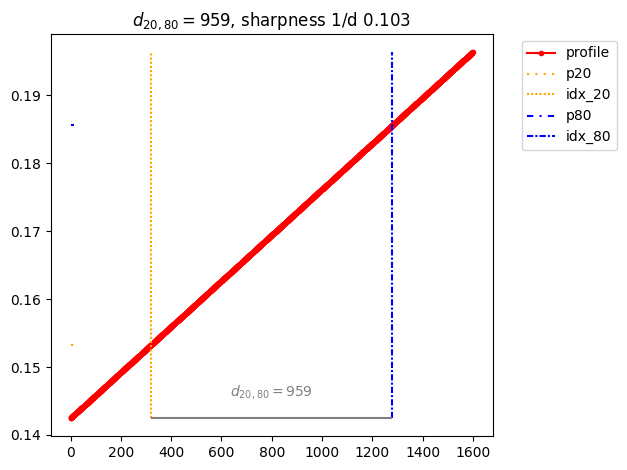

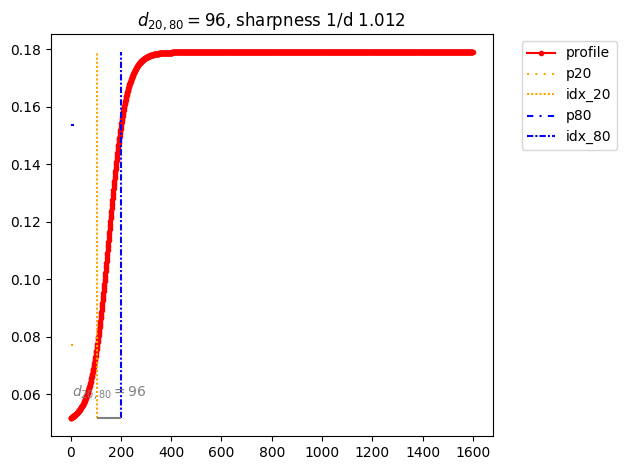

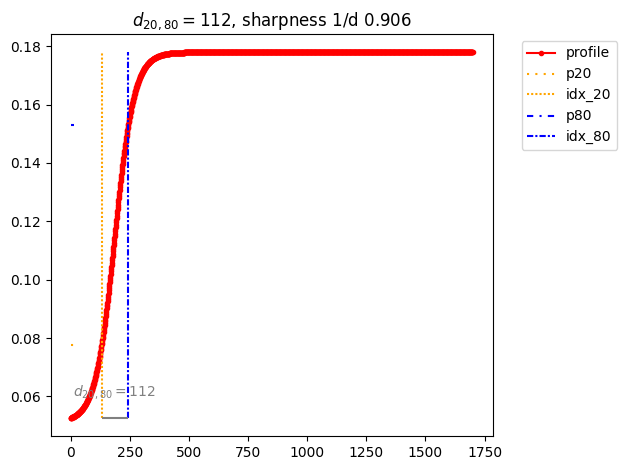

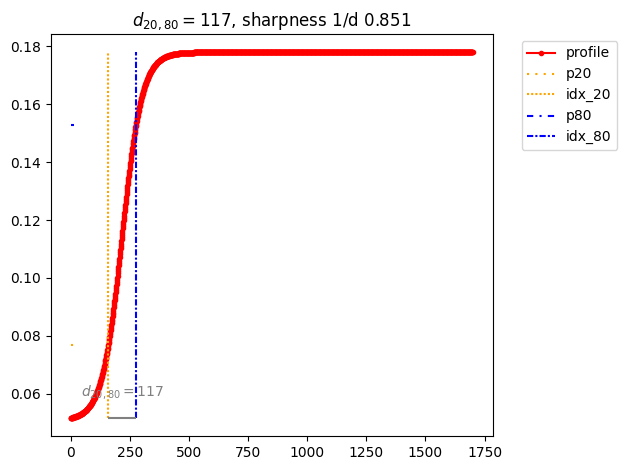

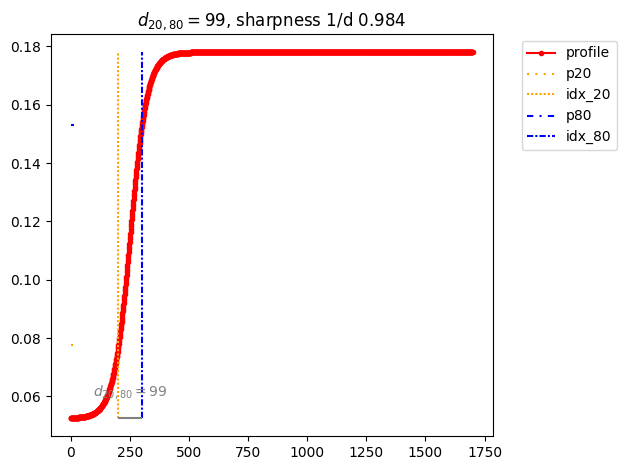

In [50]:
p2 = (centers_dict['cy'][0], centers_dict['cy'][0])
for i in range(  len(all_dict['cx'][0])  ):
    p1 = (all_dict['cy'][0][i], all_dict['cx'][0][i])
    values, coords = sample_line_from_image(recon[:,:,0], p1, p2, num=100*compute_distance_two_points_2d(p1, p2, bool_round=True))
    fitted, params, x_centered = fit_sigmoid(values)
    dict_20_80_statistics =  compute_20_80_statistics(fitted, coords)
    plot_20_80_statistics(fitted, dict_20_80_statistics)